<h1>Importing Necessary Libraries </h1>

In [193]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import seaborn as sns
import math

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from datetime import datetime

<h1>4. Application Train/Test Datasets </h1>

In [194]:
def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

<h2>4.1. Basic Overview of the Train Data </h2>

In [195]:
reduce_ratio = 0.05

train_data = reduce_memory_usage(pd.read_csv('../data/home-credit-default-risk/application_train.csv'))
rows_to_keep = int(len(train_data) * reduce_ratio)
train_data = train_data.sample(n=rows_to_keep, random_state=42)
print('Number of data points : ', train_data.shape[0])
print('Number of features : ', train_data.shape[1])
train_data.head()

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Number of data points :  15375
Number of features :  122


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
245895,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
98194,214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
36463,142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
249923,389171,0,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
158389,283617,0,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0


In [196]:
print('Features : ', train_data.columns.values)

Features :  ['SK_ID_CURR' 'TARGET' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTRANCES

<h2>4.2. Basic Overview of the Test Data </h2>

In [197]:
test_data = reduce_memory_usage(pd.read_csv('../data/home-credit-default-risk/application_test.csv'))
print('Number of data points : ', test_data.shape[0])
print('Number of features : ', test_data.shape[1])
test_data.head()

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Number of data points :  48744
Number of features :  121


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


<h4> Observations </h4>

* The Test Data has all the features same as the Train data except the 'Target' column.

<h2> 4.3 Application Train Data Analysis </h2>

<h3> 4.3.1 Univariate Analysis : Target </h3>

In [198]:
train_data['TARGET'].value_counts()

TARGET
0    14121
1     1254
Name: count, dtype: int64

Number of customers who will not repay the loan on time:  1254 , ( 8.15609756097561 %)
Number of customers who will repay the loan on time:  14121 , ( 91.84390243902439 %)


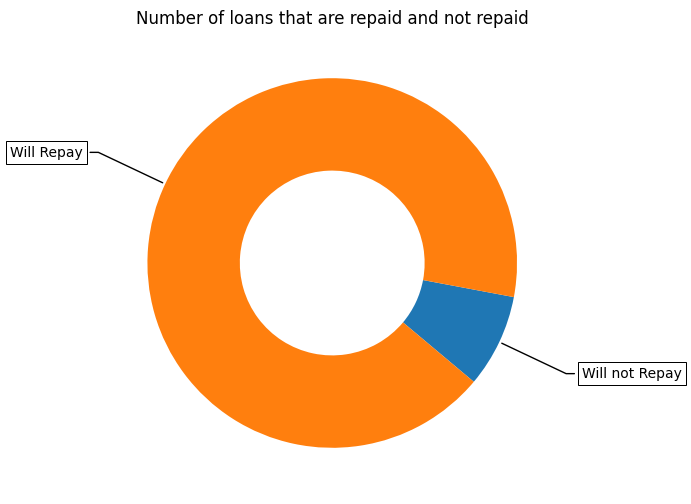

In [199]:
y_value_counts = train_data['TARGET'].value_counts()
print("Number of customers who will not repay the loan on time: ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of customers who will repay the loan on time: ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Will not Repay", "Will Repay"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5),\
                       startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of loans that are repaid and not repaid")

plt.show()

<h4> Function to plot the Stacked Bar Plot </h4>

In [200]:
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])
    
    if len(data[xtick].unique())<5:
        plt.figure(figsize=(5,5))
    elif len(data[xtick].unique())>5 & len(data[xtick].unique())<10:
        plt.figure(figsize=(7,7))
    else:
        plt.figure(figsize=(15,15))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Loans')
    plt.title('Number of loans aproved vs rejected')
    plt.xticks(ticks=ind,rotation=90,labels= list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('capable', 'not capable'))
    plt.show()

<h4> Function to plot the Univariate Bar Plot </h4>

In [201]:
def univariate_barplots(data, col1, col2='TARGET', top=False):
    temp = pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    temp['total'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

<h3> 4.3.2 Univariate Analysis : Name_Contract_Type </h3>

In [202]:
train_data['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         13938
Revolving loans     1437
Name: count, dtype: int64

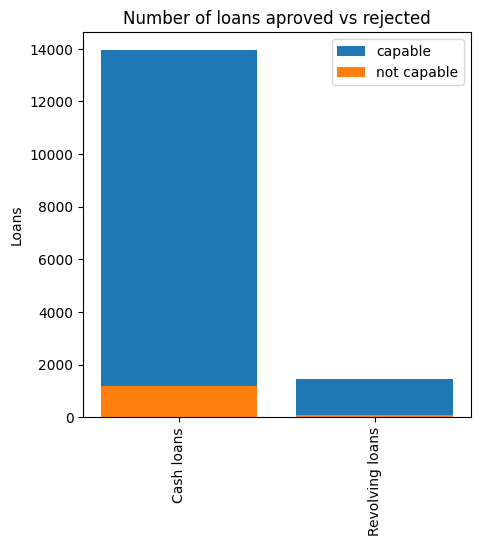

  NAME_CONTRACT_TYPE  TARGET  total       Avg
0         Cash loans    1172  13938  0.084087
1    Revolving loans      82   1437  0.057063
  NAME_CONTRACT_TYPE  TARGET  total       Avg
0         Cash loans    1172  13938  0.084087
1    Revolving loans      82   1437  0.057063


In [203]:
univariate_barplots(train_data, 'NAME_CONTRACT_TYPE', 'TARGET', False)

<h4> Observations : </h4>

* Most of the people are taking loans in the form of cash loans instead of revolving loans such as credit cards.


<h3> 4.3.3 Univariate Analysis : Code_Gender </h3>

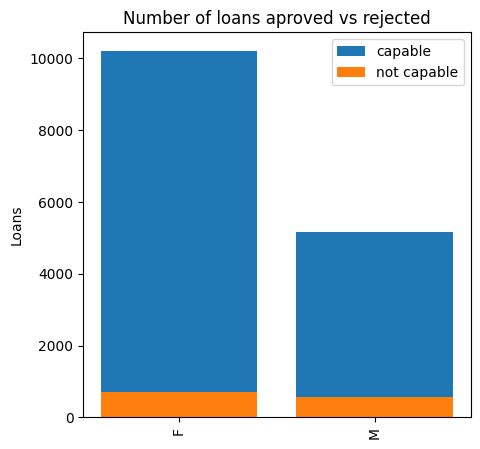

  CODE_GENDER  TARGET  total       Avg
0           F     701  10219  0.068598
1           M     553   5156  0.107254
  CODE_GENDER  TARGET  total       Avg
0           F     701  10219  0.068598
1           M     553   5156  0.107254


In [204]:
univariate_barplots(train_data, 'CODE_GENDER', 'TARGET', False)

<h4> Observations : </h4>

* The interesting part over here is the fact that Women took much more number of loans as compared to Men : Whereas Women took a total of 202K+ loans, Men only took 105K+ loans. 
* However, at the same time, Men are slightly more capable of repaying the loan as compared to Women. Whereas Men are able to repay their loans in 10% of the cases, Women are only able to repay in 7% of the cases.
* There are 4 entries where Gender='XNA'. Since this is not providing us with much information, we can remove these entries later on.

<h3> 4.3.4 Univariate Analysis : Flag_Own_Car </h3>

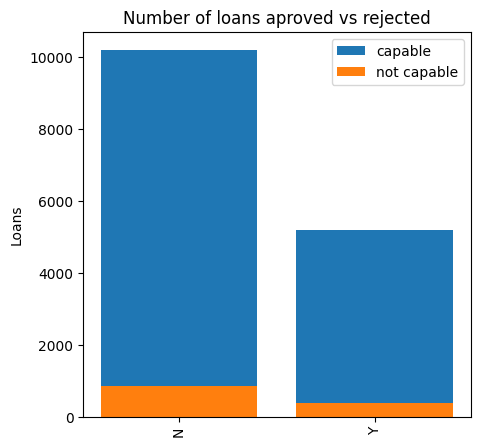

  FLAG_OWN_CAR  TARGET  total       Avg
0            N     860  10178  0.084496
1            Y     394   5197  0.075813
  FLAG_OWN_CAR  TARGET  total       Avg
0            N     860  10178  0.084496
1            Y     394   5197  0.075813


In [205]:
univariate_barplots(train_data, 'FLAG_OWN_CAR', 'TARGET', False)

<h4> Observations : </h4>

* Most of the applicants for loans do not own a car. 
* However, there is not much difference in the loan repayment status for the customer based on this information (8.5% and 7.2% respectively). We can conclude that this feature is not very useful.

<h3> 4.3.5 Univariate Analysis : Flag_Own_Realty </h3>

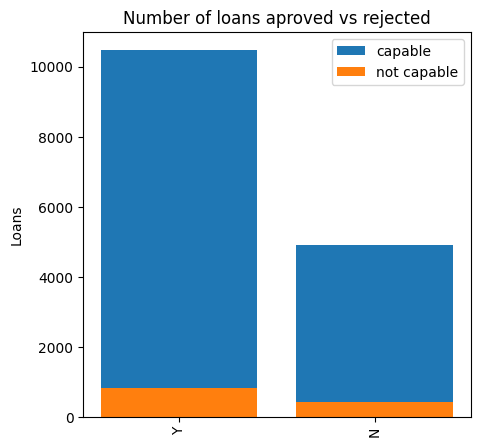

  FLAG_OWN_REALTY  TARGET  total       Avg
1               Y     835  10466  0.079782
0               N     419   4909  0.085353
  FLAG_OWN_REALTY  TARGET  total       Avg
1               Y     835  10466  0.079782
0               N     419   4909  0.085353


In [206]:
univariate_barplots(train_data, 'FLAG_OWN_REALTY', 'TARGET', False)

<h4> Observations : </h4>

* Most of the applicants for loans own a flat/house, which is a little surprising.
* However, again, there is not much difference in the loan repayment status for the customer based on this information (7.9% and 8.3% respectively). We can conclude that this feature is not very useful.

<h3> 4.3.6 Univariate Analysis : Cnt_Children </h3>

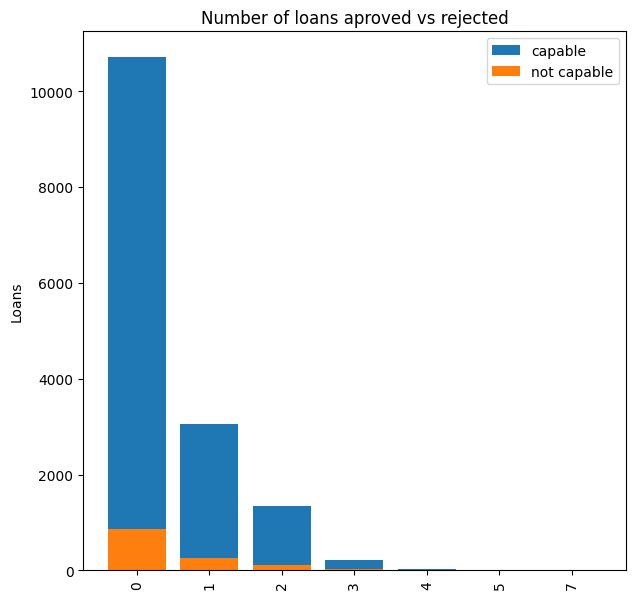

   CNT_CHILDREN  TARGET  total       Avg
0             0     855  10713  0.079810
1             1     262   3063  0.085537
2             2     110   1352  0.081361
3             3      23    214  0.107477
4             4       3     26  0.115385
   CNT_CHILDREN  TARGET  total       Avg
2             2     110   1352  0.081361
3             3      23    214  0.107477
4             4       3     26  0.115385
5             5       1      6  0.166667
6             7       0      1  0.000000


In [207]:
univariate_barplots(train_data, 'CNT_CHILDREN', 'TARGET', False)

<h4> Observations : </h4>

* The applicants having no children take considerably higher number of loans.
* However, again, there is not much difference in the loan repayment status for the customer based on this information. We can conclude that this feature is not very useful.

<h3> 4.3.7 Univariate Analysis : Amt_Income_Total </h3>

In [208]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
income_data = train_data.groupby('SK_ID_CURR').agg({'AMT_INCOME_TOTAL':'mean'}).reset_index()
income_data.head(2)

,SK_ID_CURR,AMT_INCOME_TOTAL
0,100004,67500.0
1,100020,108000.0


In [209]:
income_data_final = pd.merge(train_data, income_data, on='SK_ID_CURR', how='left')

approved_income = income_data_final[income_data_final['TARGET']==0]['AMT_INCOME_TOTAL_x'].values
rejected_income = income_data_final[income_data_final['TARGET']==1]['AMT_INCOME_TOTAL_x'].values

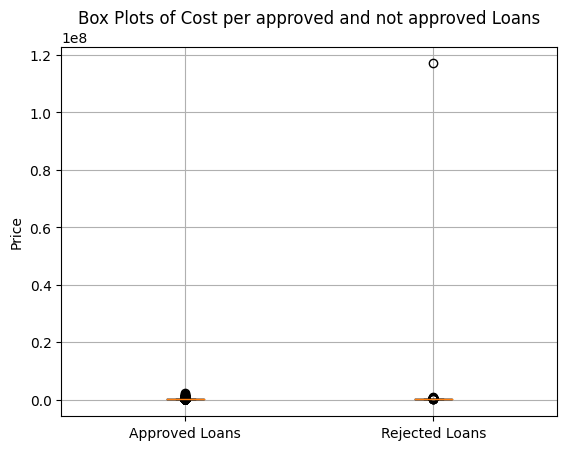

In [210]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_income, rejected_income])
plt.title('Box Plots of Cost per approved and not approved Loans')
plt.xticks([1,2],('Approved Loans','Rejected Loans'))
plt.ylabel('Price')
plt.grid()
plt.show()

In [211]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Loans", "Not Approved Loans"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_income,i), 3),\
               np.round(np.percentile(rejected_income,i), 3)])
print(x)

+------------+----------------+--------------------+
| Percentile | Approved Loans | Not Approved Loans |
+------------+----------------+--------------------+
|     0      |    27000.0     |      27000.0       |
|     5      |    67500.0     |      67500.0       |
|     10     |    81000.0     |      81000.0       |
|     15     |    90000.0     |      90000.0       |
|     20     |    99000.0     |      94500.0       |
|     25     |    112500.0    |      112500.0      |
|     30     |    112500.0    |      112500.0      |
|     35     |    126000.0    |      117000.0      |
|     40     |    135000.0    |      135000.0      |
|     45     |    135000.0    |      135000.0      |
|     50     |    153000.0    |      135000.0      |
|     55     |    157500.0    |      149175.0      |
|     60     |    166500.0    |      157500.0      |
|     65     |    180000.0    |      166500.0      |
|     70     |    189000.0    |      180000.0      |
|     75     |    202500.0    |      202500.0 

<h4> Observations : </h4>

* We can see over here that till the 45th percentile, both the Approved as well as Non-Approved loans have mostly the same value.
* However, as we go higher, as the customer's income increases, so do the chances of his loan getting approved.

<h3> 4.3.8 Univariate Analysis : Amt_Credit </h3>

In [212]:
approved_loan_credit = train_data[train_data['TARGET']==0]['AMT_CREDIT'].values
rejected_loan_credit = train_data[train_data['TARGET']==1]['AMT_CREDIT'].values

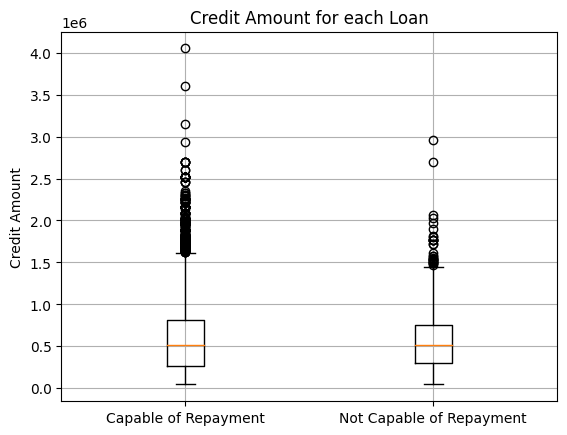

In [213]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_loan_credit, rejected_loan_credit])
plt.title('Credit Amount for each Loan')
plt.xticks([1,2],('Capable of Repayment','Not Capable of Repayment'))
plt.ylabel('Credit Amount')
plt.grid()
plt.show()

<h4> Observations : </h4>

* We can see from the Boxplot above that the Median Value of the Credit Amount of the Customers who are capable of loan repayment is slightly larger than the Median Value of Customers who are not capable of repayment.
* This basically means that the customers with higher credit amount have a slightly higher chances of being capable of loan repayment than customers with lower credit amount.

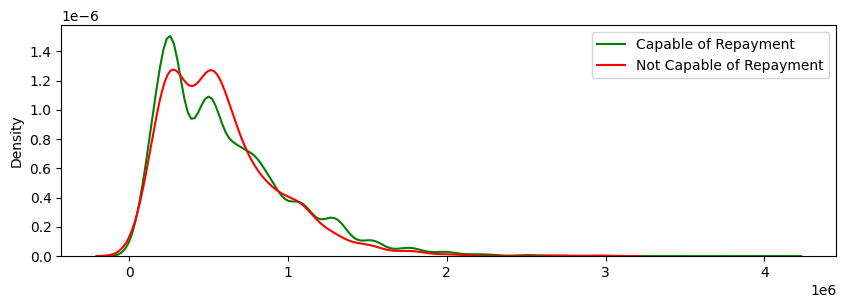

In [214]:
plt.figure(figsize=(10,3))
sns.distplot(approved_loan_credit,hist=False,label="Capable of Repayment", color='green')
sns.distplot(rejected_loan_credit,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* We can observe from above that the Credit Amount for most of the loans taken is less than 10 lakhs.

<h3> 4.3.9 Univariate Analysis : Amt_Annuity </h3>

In [215]:
capable_loan_annuity = train_data[train_data['TARGET']==0]['AMT_ANNUITY'].values
not_capable_loan_annuity = train_data[train_data['TARGET']==1]['AMT_ANNUITY'].values

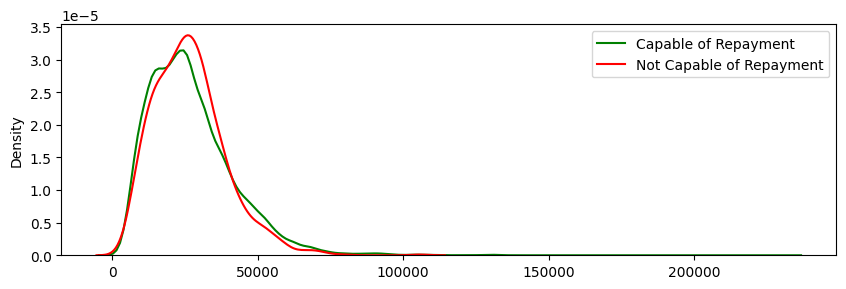

In [216]:
plt.figure(figsize=(10,3))
sns.distplot(capable_loan_annuity,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_loan_annuity,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* Most people pay annuity below Rs. 50K for the loans.

<h3> 4.3.10 Univariate Analysis : Amt_Goods_Price </h3>

In [217]:
capable_loan_goods_price = train_data[train_data['TARGET']==0]['AMT_GOODS_PRICE'].values
not_capable_loan_goods_price = train_data[train_data['TARGET']==1]['AMT_GOODS_PRICE'].values

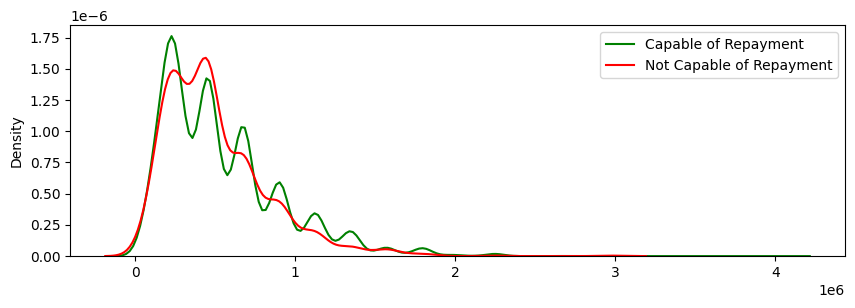

In [218]:
plt.figure(figsize=(10,3))
sns.distplot(capable_loan_goods_price,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_loan_goods_price,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* Most number of loans are given for goods that are priced below Rs. 10 lakhs.

<h3> 4.3.11 Univariate Analysis : Name_Type_Suite </h3>

In [219]:
train_data['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Other_B', nan,
       'Children', 'Group of people', 'Other_A'], dtype=object)

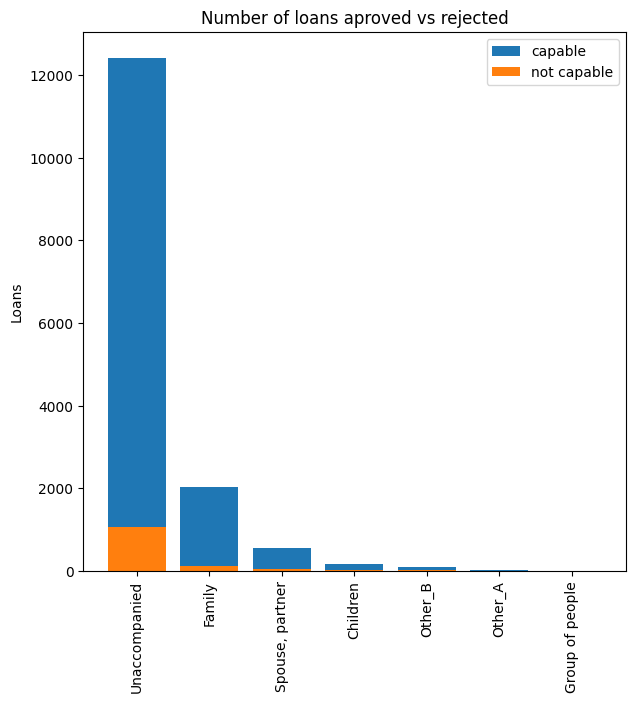

   NAME_TYPE_SUITE  TARGET  total       Avg
6    Unaccompanied    1059  12422  0.085252
1           Family     121   2036  0.059430
5  Spouse, partner      42    549  0.076503
0         Children      15    166  0.090361
4          Other_B      13     94  0.138298
   NAME_TYPE_SUITE  TARGET  total       Avg
5  Spouse, partner      42    549  0.076503
0         Children      15    166  0.090361
4          Other_B      13     94  0.138298
3          Other_A       1     31  0.032258
2  Group of people       1     10  0.100000


In [220]:
univariate_barplots(train_data, 'NAME_TYPE_SUITE', 'TARGET', False)

<h4> Observations : </h4>

* For the various types of people accompanying the client for loan, the client comes unaccompanied to the bank in the most number of cases, out of which approx. 92% of the time, the bank finds the client to be capable of loan repayment whereas the remaining 8% of the time, the client is not capable of the same. 
* Both in capability and non capability, 'Unaccompanied' as a class is the majority class in this case. 
* The curve over here falls very sharply, which means that there is a lot of variability.

<h3> 4.3.12 Univariate Analysis : Name_Income_Type </h3>

In [221]:
train_data['NAME_INCOME_TYPE'].unique()

array(['Commercial associate', 'Working', 'State servant', 'Pensioner',
       'Student', 'Maternity leave'], dtype=object)

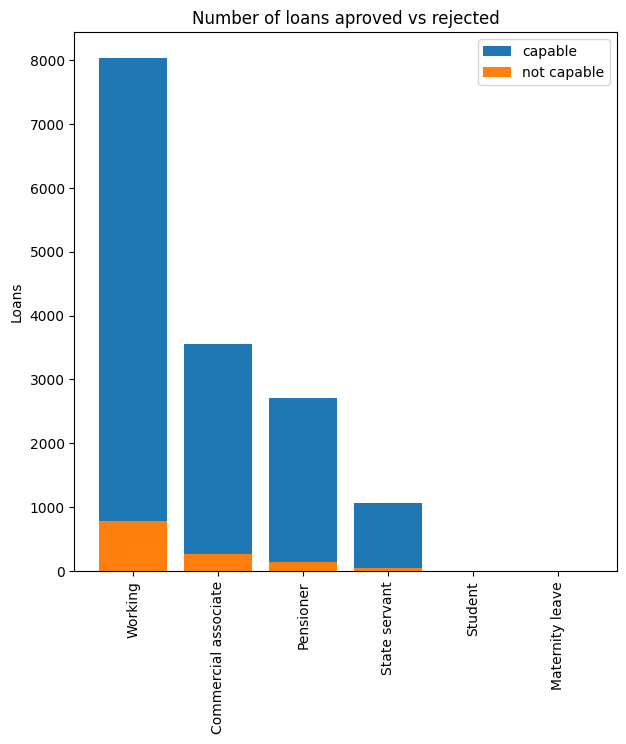

       NAME_INCOME_TYPE  TARGET  total       Avg
5               Working     783   8035  0.097449
0  Commercial associate     264   3562  0.074116
2             Pensioner     150   2711  0.055330
3         State servant      57   1064  0.053571
4               Student       0      2  0.000000
       NAME_INCOME_TYPE  TARGET  total       Avg
0  Commercial associate     264   3562  0.074116
2             Pensioner     150   2711  0.055330
3         State servant      57   1064  0.053571
4               Student       0      2  0.000000
1       Maternity leave       0      1  0.000000


In [222]:
train_data['NAME_INCOME_TYPE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'NAME_INCOME_TYPE', 'TARGET', False)

<h4> Observations : </h4>

* The people who are working take the most number of loans whereas Commercial Associates, Pensioners and State Servants take considerably lesser number of loans.
* We have very little datapoints related to Unemployed people, Students, Businessmen and women on Maternity leave. Again, there's a lot of variability in this scenario.
* One interesting observation over here is the fact that whatever loans the students and businessmen have applied to, they have been deemed capable of repayment of the same.

<h3> 4.3.13 Univariate Analysis : Name_Education_Type </h3>

In [223]:
train_data['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Lower secondary', 'Incomplete higher', 'Academic degree'],
      dtype=object)

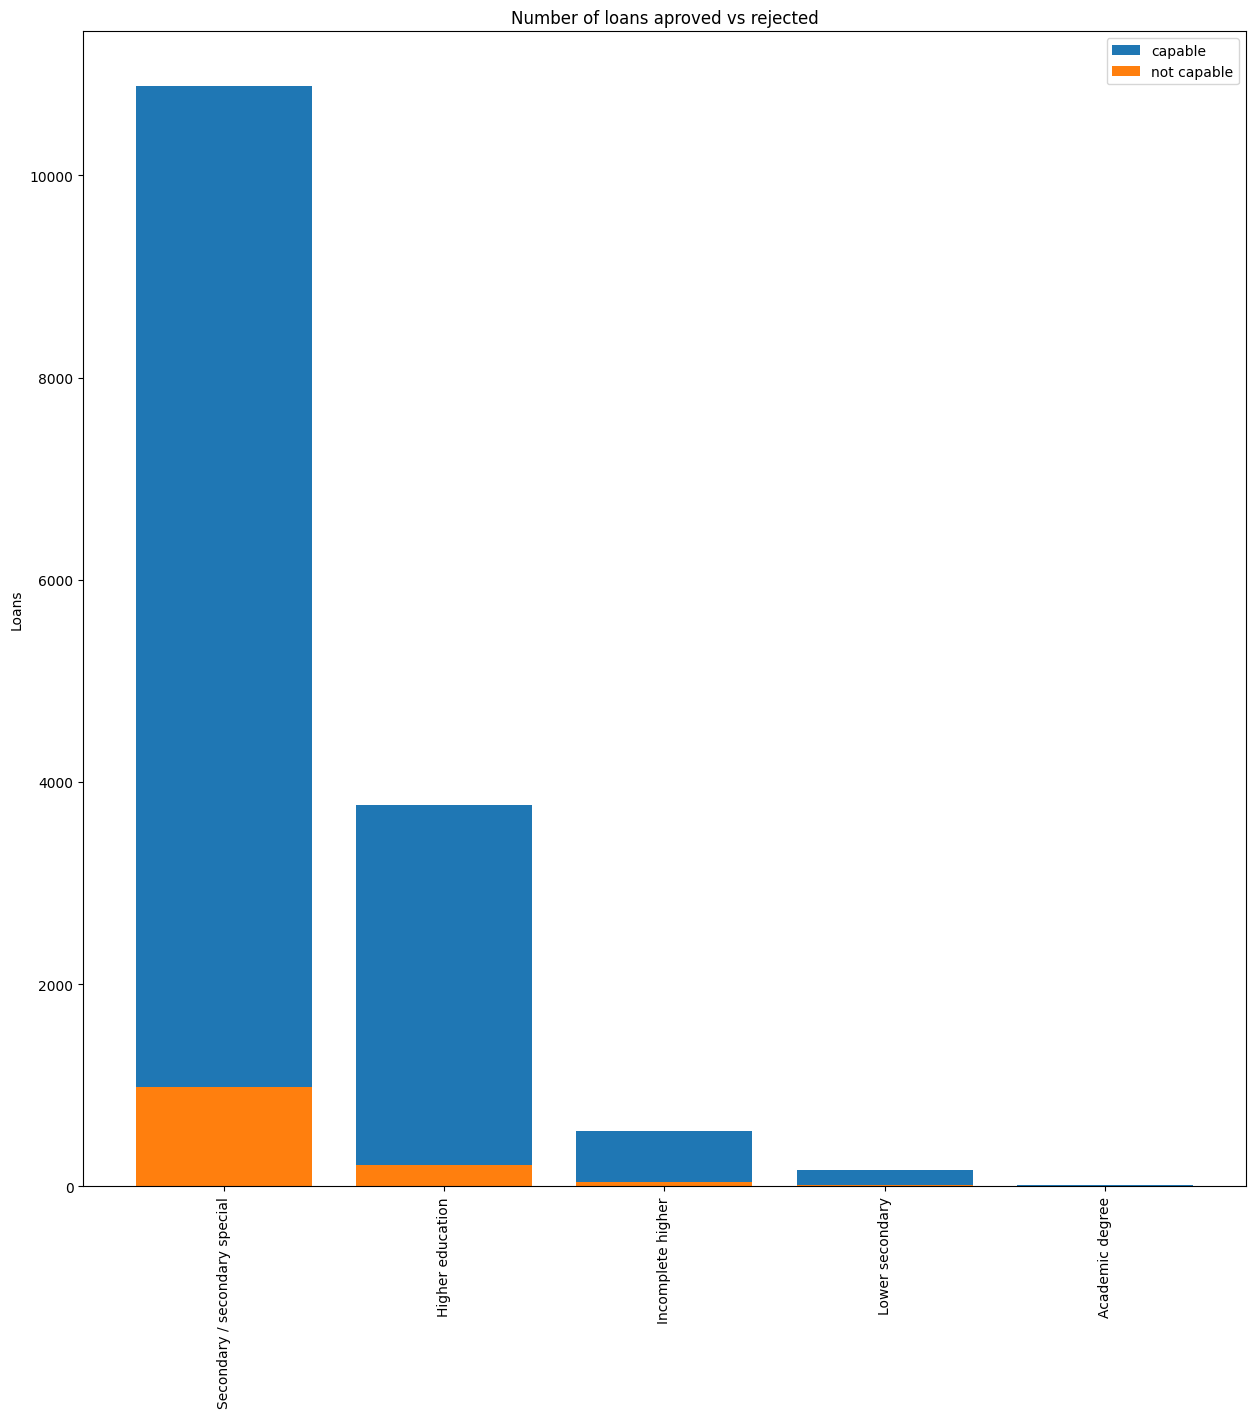

             NAME_EDUCATION_TYPE  TARGET  total       Avg
4  Secondary / secondary special     985  10880  0.090533
1               Higher education     211   3776  0.055879
2              Incomplete higher      45    545  0.082569
3                Lower secondary      13    164  0.079268
0                Academic degree       0     10  0.000000
             NAME_EDUCATION_TYPE  TARGET  total       Avg
4  Secondary / secondary special     985  10880  0.090533
1               Higher education     211   3776  0.055879
2              Incomplete higher      45    545  0.082569
3                Lower secondary      13    164  0.079268
0                Academic degree       0     10  0.000000


In [224]:
train_data['NAME_EDUCATION_TYPE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'NAME_EDUCATION_TYPE', 'TARGET', False)

<h4> Observations : </h4>

* Again, there's a lot of variability in this scenario among education types of the applicants.
* People with Secondary/Secondary Special as the highest level of education apply for most number of loans and they are also the highest defaulters. However, the default percentage is not very different across various education levels.

<h3> 4.3.14 Univariate Analysis : Name_Family_Status </h3>

In [225]:
train_data['NAME_FAMILY_STATUS'].unique()

array(['Married', 'Single / not married', 'Widow', 'Separated',
       'Civil marriage', 'Unknown'], dtype=object)

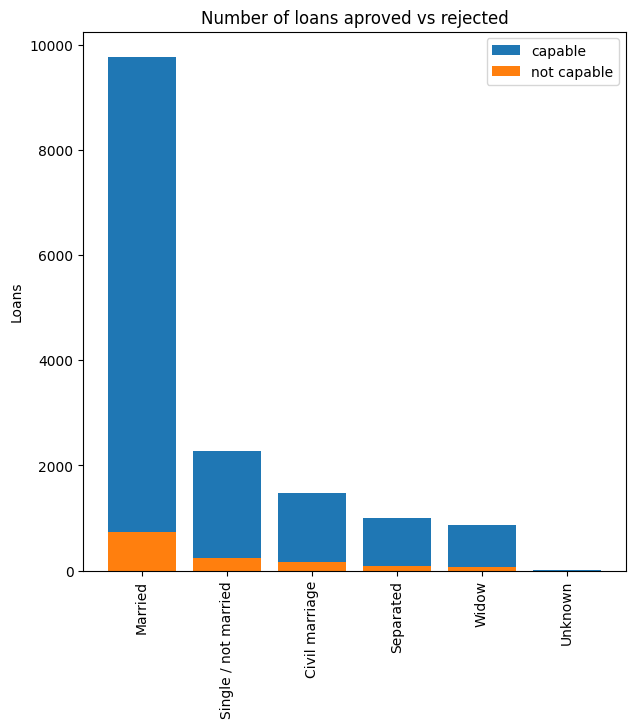

     NAME_FAMILY_STATUS  TARGET  total       Avg
1               Married     726   9759  0.074393
3  Single / not married     232   2268  0.102293
0        Civil marriage     159   1479  0.107505
2             Separated      78   1005  0.077612
5                 Widow      59    863  0.068366
     NAME_FAMILY_STATUS  TARGET  total       Avg
3  Single / not married     232   2268  0.102293
0        Civil marriage     159   1479  0.107505
2             Separated      78   1005  0.077612
5                 Widow      59    863  0.068366
4               Unknown       0      1  0.000000


In [226]:
train_data['NAME_FAMILY_STATUS'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'NAME_FAMILY_STATUS', 'TARGET', False)

<h4> Observations : </h4>

* There is variability among the Family Status of the applicants but there is not much variability if the majority class (Married) is ignored.
* Married people apply for the most number of loans and the number of people deemed incapable of repayment is also the highest.

<h3> 4.3.15 Univariate Analysis : Name_Housing_Type </h3>

In [227]:
train_data['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'With parents', 'Municipal apartment',
       'Rented apartment', 'Co-op apartment', 'Office apartment'],
      dtype=object)

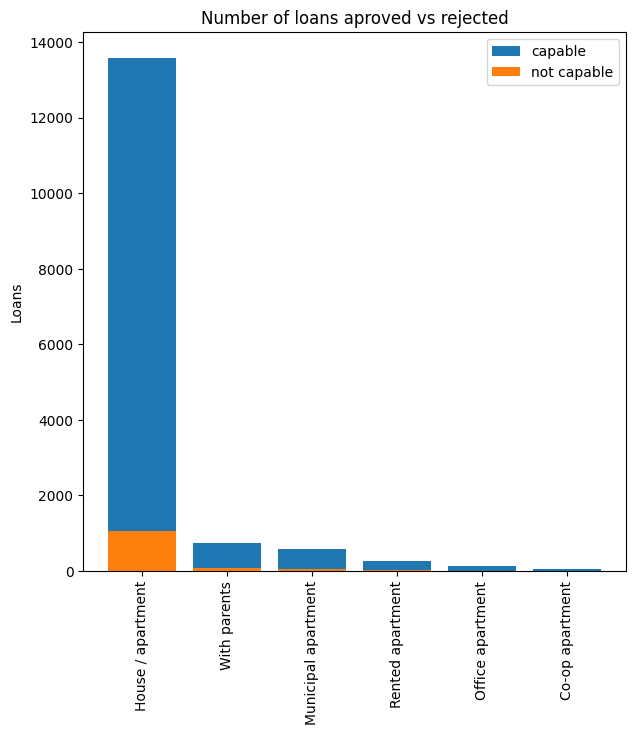

     NAME_HOUSING_TYPE  TARGET  total       Avg
1    House / apartment    1058  13588  0.077863
5         With parents      91    755  0.120530
2  Municipal apartment      51    592  0.086149
4     Rented apartment      38    256  0.148438
3     Office apartment      12    133  0.090226
     NAME_HOUSING_TYPE  TARGET  total       Avg
5         With parents      91    755  0.120530
2  Municipal apartment      51    592  0.086149
4     Rented apartment      38    256  0.148438
3     Office apartment      12    133  0.090226
0      Co-op apartment       4     51  0.078431


In [228]:
train_data['NAME_HOUSING_TYPE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'NAME_HOUSING_TYPE', 'TARGET', False)

<h4> Observations : </h4>

* People living in a House/Apartment apply for the most number of loans and the number of people deemed incapable of repayment in this case is also the highest, whereas if percentages are looked at, people living in rented apartment have the highest chance of default.

<h3> 4.3.16 Univariate Analysis : Days_Birth </h3>

In [229]:
capable_days_birth = train_data[train_data['TARGET']==0]['DAYS_BIRTH'].values/365
not_capable_days_birth = train_data[train_data['TARGET']==1]['DAYS_BIRTH'].values/365

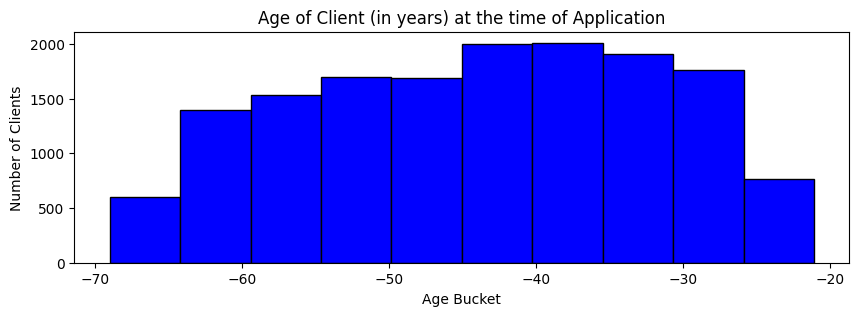

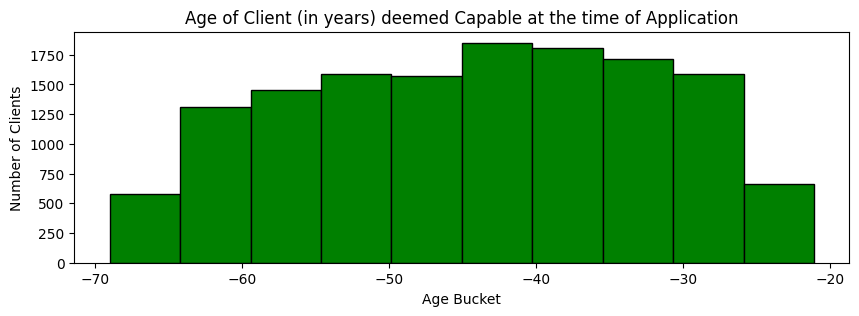

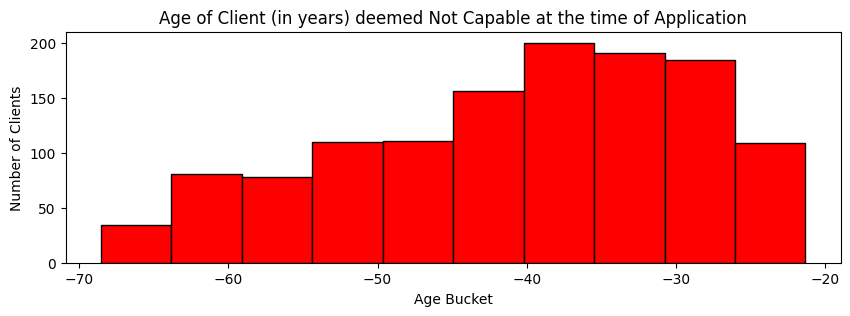

In [230]:
plt.figure(figsize=(10,3))
plt.hist(train_data['DAYS_BIRTH'].values/365, bins=10, edgecolor='black', color='blue')
plt.title('Age of Client (in years) at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(capable_days_birth, bins=10, edgecolor='black', color='green')
plt.title('Age of Client (in years) deemed Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(not_capable_days_birth, bins=10, edgecolor='black', color='red')
plt.title('Age of Client (in years) deemed Not Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* Most number of people applying for loans are in the range of (35-40) years whereas this is followed by people in the range of (40-45) years whereas the number of applicants in people aged <25 or aged>65 is very low.
* Again, for the people who are deemed capable of loan repayment, people in the same age buckets of (35-40) years and (40-45) years are deemed to be most capable. 
* People aged in the buckets (25-30) years and (30-35) years have a large chance of being deemed not capable for loan repayment.

<h3> 4.3.17 Univariate Analysis : Days_Employed </h3>

In [231]:
capable_days_employed = train_data[train_data['TARGET']==0]['DAYS_EMPLOYED'].values/365
not_capable_days_employed = train_data[train_data['TARGET']==1]['DAYS_EMPLOYED'].values/365

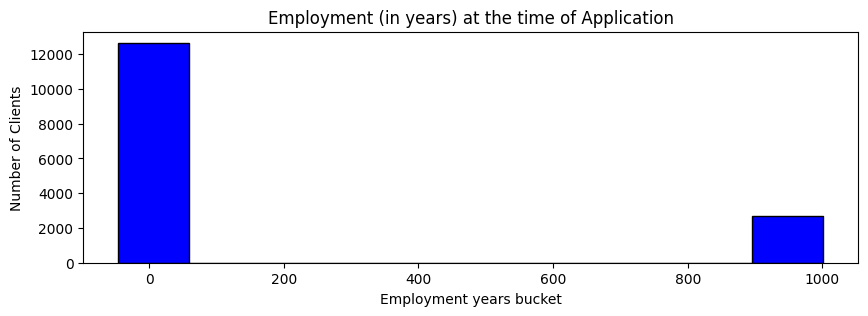

In [232]:
plt.figure(figsize=(10,3))
plt.hist(train_data['DAYS_EMPLOYED'].values/365, bins=10, edgecolor='black', color='blue')
plt.title('Employment (in years) at the time of Application')
plt.xlabel('Employment years bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* Here also, we have already converted the days into years for easy analysis, and we can see from the histogram that there are some clients that have worked for 1000 years. 
* This is clearly impossible and is an outlier, which we will deal with later.

### 4.3.18 Univariate Analysis: Days_Registration

Days_Registration basically defines the number of days before the loan application that the client has changed the registration.

In [233]:
capable_days_registration = train_data[train_data['TARGET']==0]['DAYS_REGISTRATION'].values
not_capable_days_registration = train_data[train_data['TARGET']==1]['DAYS_REGISTRATION'].values

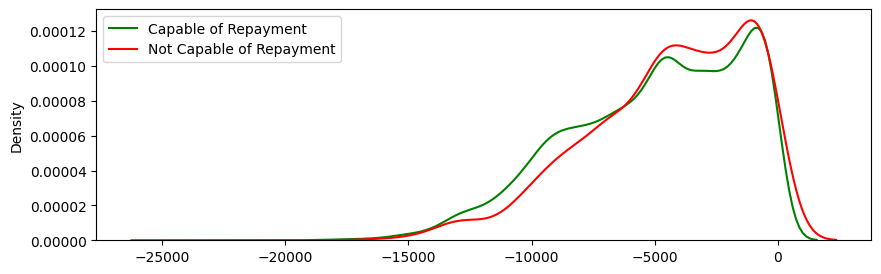

In [234]:
plt.figure(figsize=(10,3))
sns.distplot(capable_days_registration,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_days_registration,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* Most of the clients have changed their registration less than 15000 days (41 years) before the loan application, whereas in most cases it is less than 5000 days (13 years).

### 4.3.19 Univariate Analysis: Days_ID_Publish

This basically refers to the number of days before the application date that the client changed the identity document with which he applied for the loan.

In [235]:
capable_days_id_publish = train_data[train_data['TARGET']==0]['DAYS_ID_PUBLISH'].values
not_capable_days_id_publish = train_data[train_data['TARGET']==1]['DAYS_ID_PUBLISH'].values

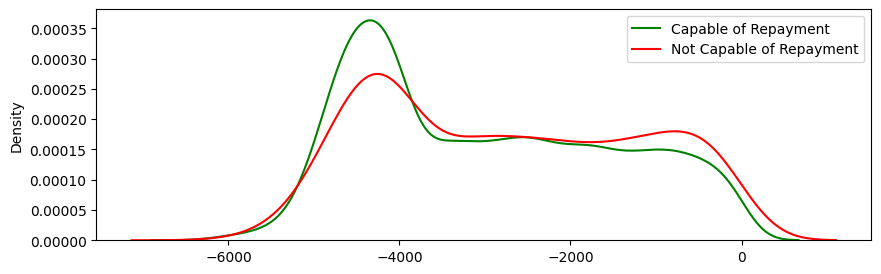

In [236]:
plt.figure(figsize=(10,3))
sns.distplot(capable_days_id_publish,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_days_id_publish,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* Most of the clients have changed their identity document around 4000 days (10.95 years) before the application date.

### 4.3.20 Univariate Analysis: Own_Car_Age

In [237]:
capable_car_age = train_data[train_data['TARGET']==0]['OWN_CAR_AGE'].values
not_capable_car_age = train_data[train_data['TARGET']==1]['OWN_CAR_AGE'].values

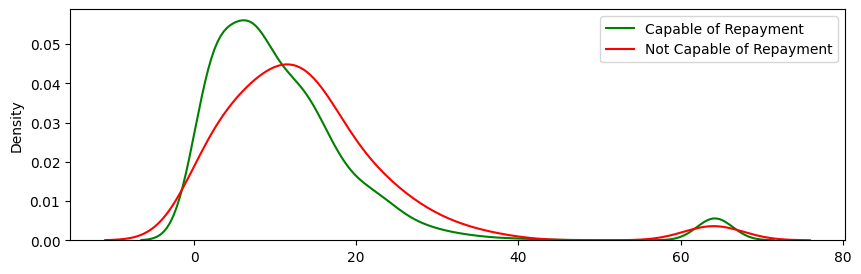

In [238]:
plt.figure(figsize=(10,3))
sns.distplot(capable_car_age,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_car_age,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* Most of the clients have their cars less than 20 years old whereas there are very few cars that are older than 20 years.

### 4.3.21 Univariate Analysis: Flag_Mobil

This is the Flag that indicates whether the loan applicant possesses a Mobile Phone or not. 1 means that yes, he/she owns a Mobile Phone whereas 0 means that he/she doesn't own a mobile phone. 

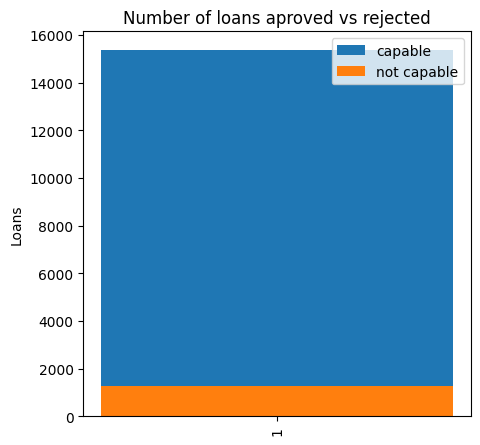

   FLAG_MOBIL  TARGET  total       Avg
0           1    1254  15375  0.081561
   FLAG_MOBIL  TARGET  total       Avg
0           1    1254  15375  0.081561


In [239]:
train_data['FLAG_MOBIL'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'FLAG_MOBIL', 'TARGET', False)

<h4> Observations : </h4>

* Out of the total 307511 loan applications in the Train Data, nearly everyone in the application owns a Mobile Phone out of which 92% are deemed capable and 8% are deemed incapable.
* There is only 1 applicant in the training data that does not own a Mobile Phone.

### 4.3.22 Univariate Analysis: Flag_Emp_Phone

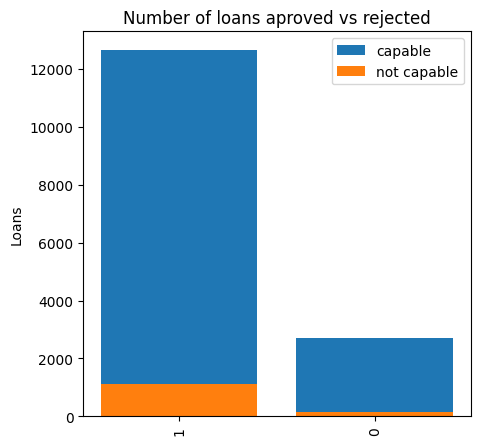

   FLAG_EMP_PHONE  TARGET  total       Avg
1               1    1104  12664  0.087176
0               0     150   2711  0.055330
   FLAG_EMP_PHONE  TARGET  total       Avg
1               1    1104  12664  0.087176
0               0     150   2711  0.055330


In [240]:
train_data['FLAG_EMP_PHONE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'FLAG_EMP_PHONE', 'TARGET', False)

<h4> Observations : </h4>

* A lot of the applicants provided their Work Phone (83%) as compared to the applicants who did not provide their work phone (17%).

### 4.3.23 Univariate Analysis: Flag_Cont_Mobile

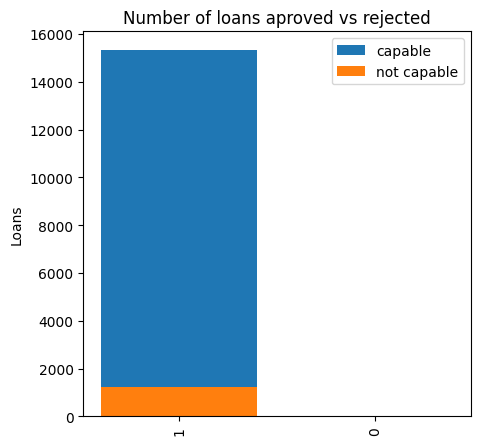

   FLAG_CONT_MOBILE  TARGET  total       Avg
1                 1    1249  15342  0.081411
0                 0       5     33  0.151515
   FLAG_CONT_MOBILE  TARGET  total       Avg
1                 1    1249  15342  0.081411
0                 0       5     33  0.151515


In [241]:
train_data['FLAG_CONT_MOBILE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'FLAG_CONT_MOBILE', 'TARGET', False)

<h4> Observations : </h4>

* 99% of the applicants had their phone reachable when the Bank tried to contact them.

### 4.3.24 Univariate Analysis: Flag_Email

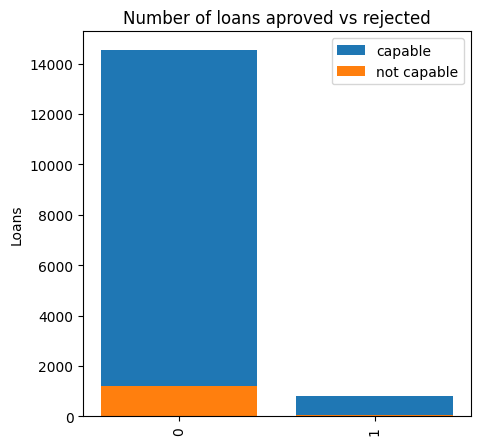

   FLAG_EMAIL  TARGET  total       Avg
0           0    1203  14549  0.082686
1           1      51    826  0.061743
   FLAG_EMAIL  TARGET  total       Avg
0           0    1203  14549  0.082686
1           1      51    826  0.061743


In [242]:
train_data['FLAG_EMAIL'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'FLAG_EMAIL', 'TARGET', False)

<h4> Observations : </h4>

* This goes on to show that approximately 94% of the clients did not provide their Email Address in the application, and only 6% of the clients provided Email details. 

### 4.3.25 Univariate Analysis: Occupation_Type

In [243]:
train_data['OCCUPATION_TYPE'].unique()

array(['Sales staff', 'Managers', 'High skill tech staff', 'Laborers',
       nan, 'Core staff', 'Accountants', 'Low-skill Laborers', 'Drivers',
       'Medicine staff', 'Secretaries', 'Security staff', 'Cooking staff',
       'Cleaning staff', 'IT staff', 'Private service staff',
       'Waiters/barmen staff', 'HR staff', 'Realty agents'], dtype=object)

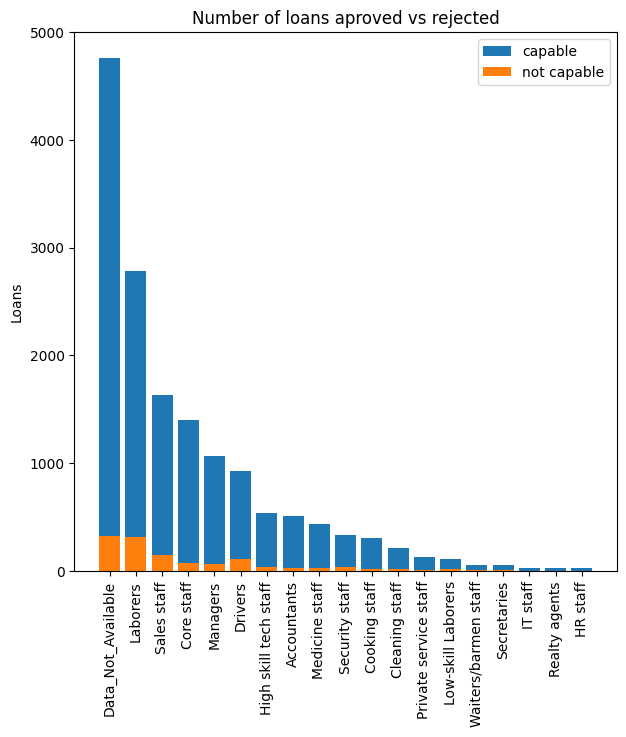

       OCCUPATION_TYPE  TARGET  total       Avg
4   Data_Not_Available     324   4762  0.068039
9             Laborers     317   2782  0.113947
15         Sales staff     147   1631  0.090129
3           Core staff      73   1405  0.051957
11            Managers      62   1067  0.058107
         OCCUPATION_TYPE  TARGET  total       Avg
18  Waiters/barmen staff      10     59  0.169492
16           Secretaries       7     58  0.120690
8               IT staff       0     31  0.000000
14         Realty agents       0     31  0.000000
6               HR staff       4     26  0.153846


In [244]:
train_data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'OCCUPATION_TYPE', 'TARGET', False)

<h4> Observations : </h4>

* Out of all the possible Occupation Types, the majority of applicants have not provided their Occupation Type in the application (approx. 31.39%) which is followed by Laborers (approx. 18%).
* Out of all the occupations, Waiters/barmen staff are considered to be the least capable of repayment followed by Laborers -> though laborers have considerably higher applications as compared to Waiters/barmen staff.

### 4.3.26 Univariate Analysis: Cnt_Fam_Members

In [245]:
train_data['CNT_FAM_MEMBERS'].isnull().sum()

1

In [246]:
#Replace NA with the most frequently occuring class for Count of Client Family Members
train_data['CNT_FAM_MEMBERS'].fillna(train_data['CNT_FAM_MEMBERS'].value_counts().idxmax(), \
                                     inplace=True)

In [247]:
capable_family_members = train_data[train_data['TARGET']==0]['CNT_FAM_MEMBERS'].values
not_capable_family_members = train_data[train_data['TARGET']==1]['CNT_FAM_MEMBERS'].values

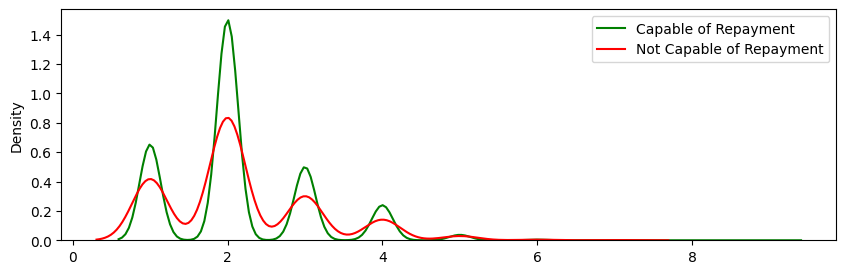

In [248]:
plt.figure(figsize=(10,3))
sns.distplot(capable_family_members,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_family_members,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* Most of the applicants have 2 Family Members and there are very few applicants with >5 family members.

### 4.3.27 Univariate Analysis: Weekday_Appr_Process_Start

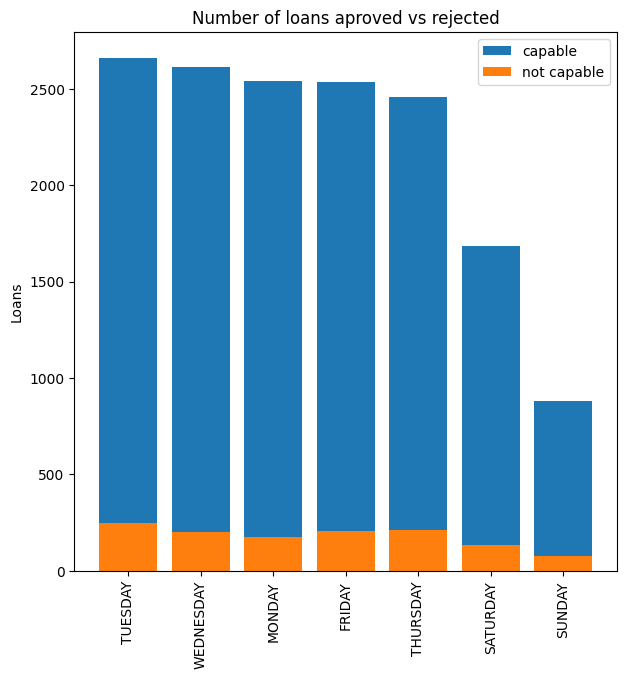

  WEEKDAY_APPR_PROCESS_START  TARGET  total       Avg
5                    TUESDAY     246   2661  0.092446
6                  WEDNESDAY     200   2613  0.076540
1                     MONDAY     176   2542  0.069237
0                     FRIDAY     208   2533  0.082116
4                   THURSDAY     212   2459  0.086214
  WEEKDAY_APPR_PROCESS_START  TARGET  total       Avg
1                     MONDAY     176   2542  0.069237
0                     FRIDAY     208   2533  0.082116
4                   THURSDAY     212   2459  0.086214
2                   SATURDAY     136   1684  0.080760
3                     SUNDAY      76    883  0.086070


In [249]:
univariate_barplots(train_data, 'WEEKDAY_APPR_PROCESS_START', 'TARGET', False)

<h4> Observations : </h4>

* This is very interesting because the number of applications are spread almost uniformly throughout the weekdays (Monday-Friday) (approx. 50K applications per day) (16-17%), whereas the number of applications is very low on a Sunday. 

### 4.3.28 Univariate Analysis: Organization_Type

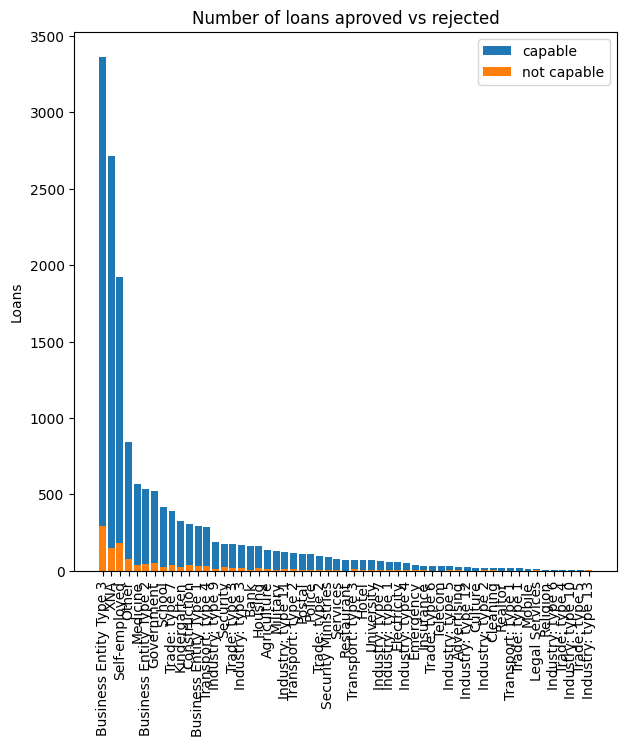

         ORGANIZATION_TYPE  TARGET  total       Avg
5   Business Entity Type 3     295   3359  0.087824
56                     XNA     150   2711  0.055330
41           Self-employed     180   1921  0.093701
32                   Other      78    842  0.092637
29                Medicine      35    569  0.061511
    ORGANIZATION_TYPE  TARGET  total       Avg
23   Industry: type 6       0      6  0.000000
47      Trade: type 4       1      5  0.200000
15  Industry: type 10       0      4  0.000000
48      Trade: type 5       1      3  0.333333
18  Industry: type 13       2      3  0.666667


In [250]:
univariate_barplots(train_data, 'ORGANIZATION_TYPE', 'TARGET', False)

<h4> Observations : </h4>

* Business people and XNA (No information provided) are the highest number of applicants but Business People and Self-Employed applicants have some of the highest default rate.

### 4.3.29 Univariate Analysis: EXT_SOURCE_1

EXT_SOURCE_1 is a Normalized Score from an External Data Source - 1. 

In [251]:
train_data['EXT_SOURCE_1'].isnull().sum()

8646

<h4> Note :</h4> 

This basically shows that approx. 173378/307511 ie. nearly 56% of the entries in the EXT_SOURCE_1 column are nulls ie. empty values, and we will look at the remaining values only. We can carry out replacement of these values with the Mean/Median/Mode for the entire numerical column but since this is a large number of nulls, we will not follow that approach.

In [252]:
capable_ext_source_1 = train_data[train_data['TARGET']==0]['EXT_SOURCE_1'].values
not_capable_ext_source_1 = train_data[train_data['TARGET']==1]['EXT_SOURCE_1'].values

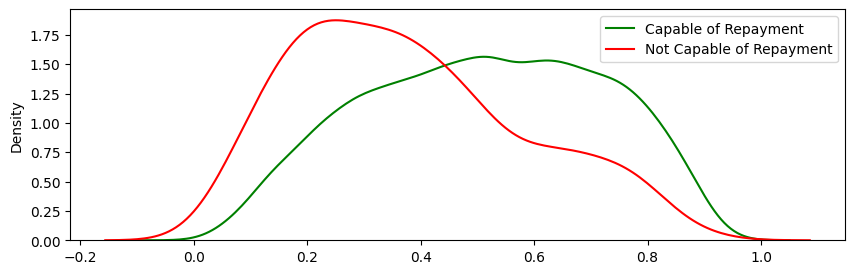

In [253]:
plt.figure(figsize=(10,3))
sns.distplot(capable_ext_source_1,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_ext_source_1,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* This is the first feature that we are seeing where there is some considerable difference among the 2 classes, as we can see from the PDF plot.
* Therefore, EXT_SOURCE_1 is going to be an important feature.

### 4.3.30 Univariate Analysis: EXT_SOURCE_2

EXT_SOURCE_2 is a Normalized Score from an External Data Source - 2. 

In [254]:
train_data['EXT_SOURCE_2'].isnull().sum()

31

<h4> Note :</h4> 

This basically shows that approx. 660/307511 ie. only 0.2% of the entries in the column are nulls. We will analyse on the non-empty values in the column.

In [255]:
capable_ext_source_2 = train_data[train_data['TARGET']==0]['EXT_SOURCE_2'].values
not_capable_ext_source_2 = train_data[train_data['TARGET']==1]['EXT_SOURCE_2'].values

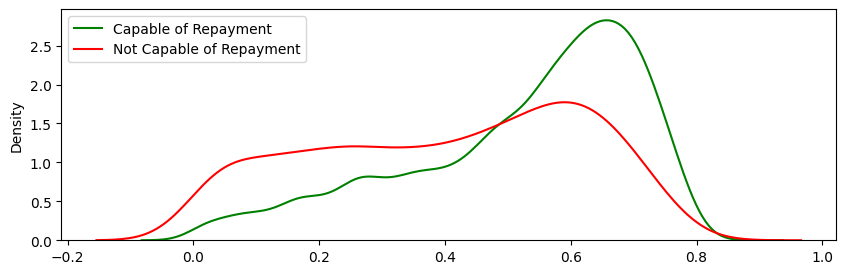

In [256]:
plt.figure(figsize=(10,3))
sns.distplot(capable_ext_source_2,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_ext_source_2,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* Again, in this case also we can see that the data is reasonably well separated and hence this will also be an important feature.

### 4.3.31 Univariate Analysis: EXT_SOURCE_3

EXT_SOURCE_3 is a Normalized Score from an External Data Source - 3. 

In [257]:
train_data['EXT_SOURCE_3'].isnull().sum()

3013

<h4> Note :</h4> 

This basically shows that 60965/307511 ie. 19% of the entries in the column are nulls. We will analyse on the non-empty values in the column.

In [258]:
capable_ext_source_3 = train_data[train_data['TARGET']==0]['EXT_SOURCE_3'].values
not_capable_ext_source_3 = train_data[train_data['TARGET']==1]['EXT_SOURCE_3'].values

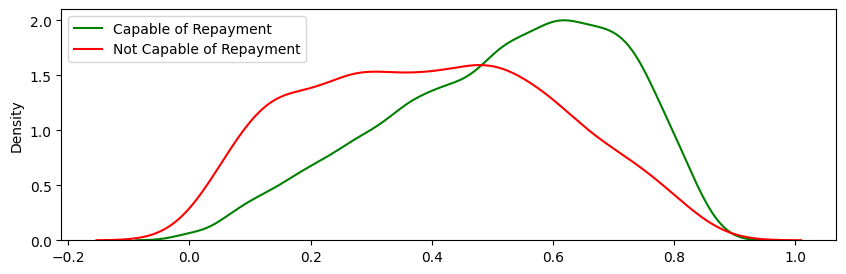

In [259]:
plt.figure(figsize=(10,3))
sns.distplot(capable_ext_source_3,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_ext_source_3,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

<h4> Observations : </h4>

* Again, the data is reasonably well separated and hence this will also be an important feature.

### 4.3.32 Univariate Analysis: Flag_Document_x

There are multiple Flag Document Columns in the Train and Test Dataframes that we are to analyse if they are going to add much value to the models that we will build or not. In order to analyse, we will first take a subset of all the columns from the Dataframe that has the term 'FLAG' present in the column name.

In [260]:
# Refer :- https://stackoverflow.com/questions/43643506/select-columns-based-on-columns-names-containing-a-specific-string-in-pandas
flag_document_df = train_data.loc[:, train_data.columns.str.contains('DOCUMENT')]
flag_document_df.head(5)

,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
245895,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98194,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36463,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
249923,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
158389,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h4> Note </h4> 

As we can see over here, we have a total of 20 Flag Document Columns in the dataframe pertaining to different documents where 1 denotes that the client has provided the corresponding document in the loan application and 0 denotes that the client has not provided the corresponding document.

In [261]:
# for column in flag_document_df:
    
#     count_0 = flag_document_df[column].value_counts()[0]
#     count_1 = flag_document_df[column].value_counts()[1]
#     total_rows = flag_document_df.shape[0]
    
#     percent_0 = np.round((count_0*100/total_rows),2)
#     percent_1 = np.round(100 - percent_0,2)
    
#     print(column, "contains percentage of 1's = ",percent_1,\
#     "and percentage of 0's =", percent_0)

<h4> Observations : </h4>

* We can see from here that the percentage of 1s (ie. the client has submitted the document) is very small in most of the cases, which means that the data is highly imbalanced and its presence in the dataset is not going to help us very much.
* However, Flag_Document_3 has a good presence of 1s and we can remove all the Flag_Document columns except this one.

### 4.3.33 Bivariate Analysis: NAME_CONTRACT_TYPE vs AMT_CREDIT

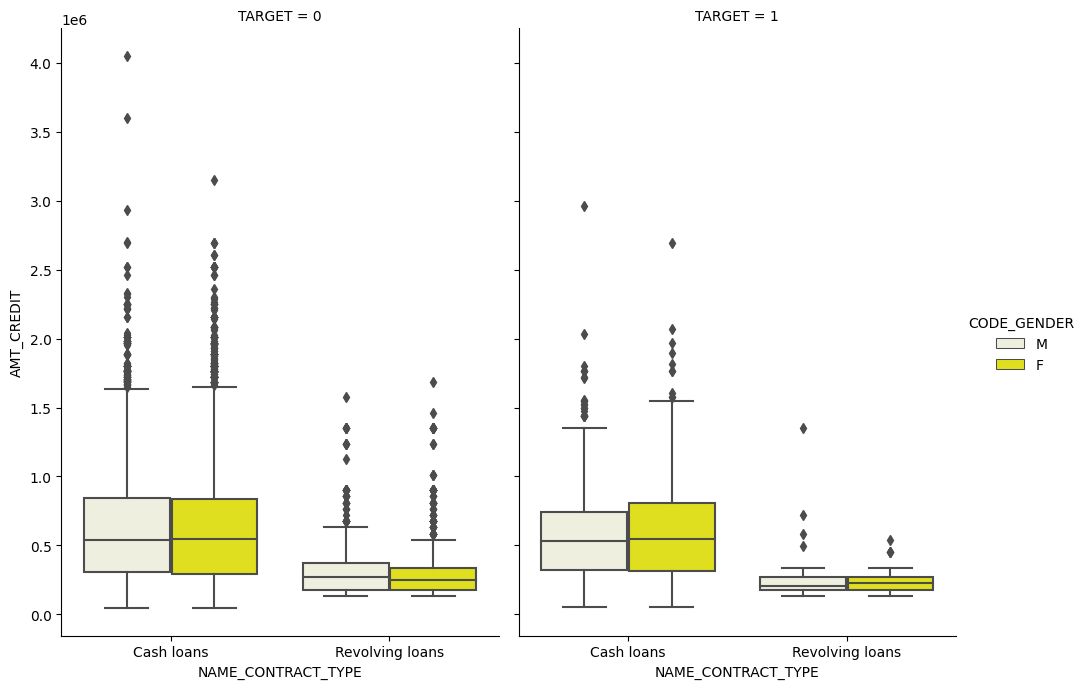

In [262]:
sns.catplot(x="NAME_CONTRACT_TYPE", y="AMT_CREDIT", hue="CODE_GENDER" ,col="TARGET",\
            data=train_data,color = "yellow",kind="box", height=7, aspect=.7)

<h4> Observations : </h4>

* This shows that Men & Women with Cash Loans have higher chances of being deemed capable of loan repayment based on their Credit Amount.

### 4.3.34 Bivariate Analysis:  AMT_CREDIT vs NAME_INCOME_TYPE

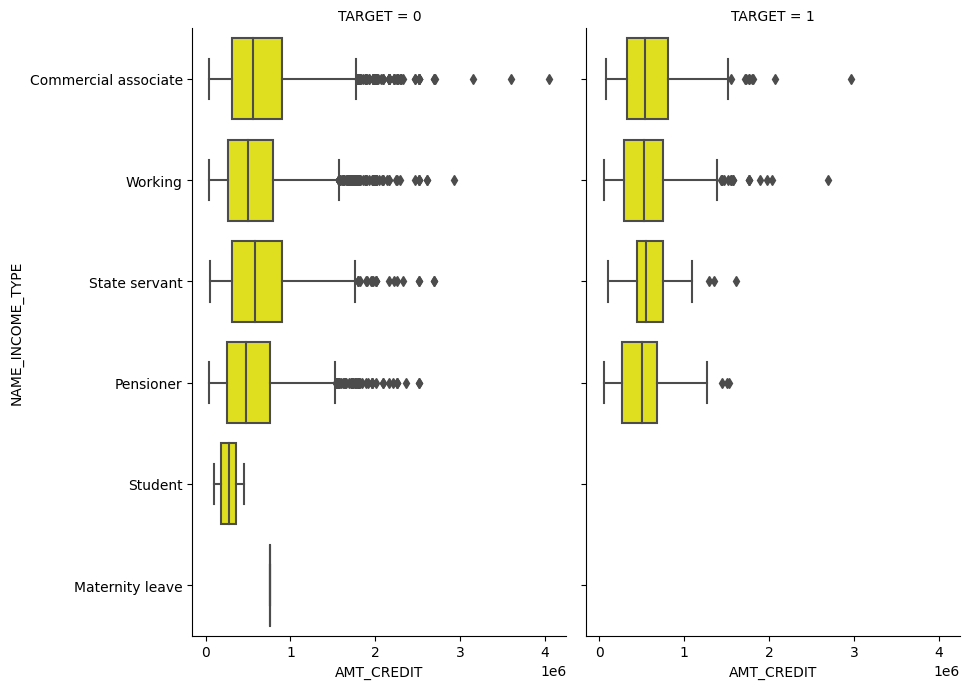

In [263]:
sns.catplot(x="AMT_CREDIT", y="NAME_INCOME_TYPE", col="TARGET",\
            data=train_data,color = "yellow",kind="box", height=7, aspect=.7);

<h4> Observations : </h4>

* This shows that Applicants with a Higher Value of Credit Amount across various income types have a Higher Likelihood of deemed capable of Loan Repayment, especially in the case of 'Unemployed','Student' and 'Businessmen'. 

### 4.3.35 Bivariate Analysis: AMT_CREDIT vs AMT_ANNUITY

<Axes: xlabel='AMT_CREDIT', ylabel='AMT_ANNUITY'>

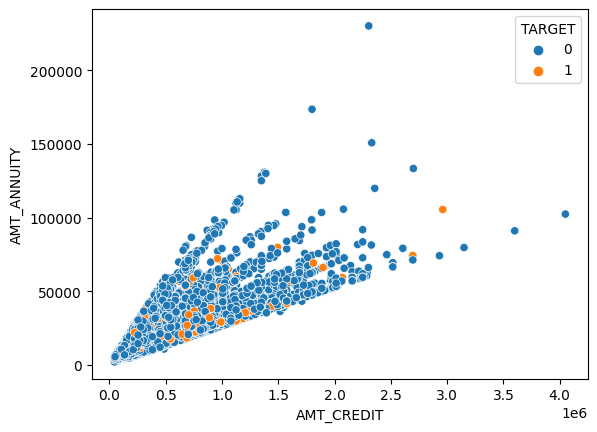

In [264]:
sns.scatterplot(
    data=train_data, x="AMT_CREDIT", y="AMT_ANNUITY", hue="TARGET",\
    sizes=(20, 200)
)

<h4> Observations : </h4>

* This shows that both the Amount Credit and Amount Annuity are directly proportional to each other. If the Credit Amount is high, the Annuity Amount for the same will also be high.
* We are able to see an almost Linear graph. However, based on these 2 numeric features, we are not able to carry out Binary Classification with the help of Simple Logistic Regression. This means we need to carry out Feature Engineering on the same.

<h2> 4.4 Fixing Null Values and Outliers </h2>

Since whatever implementations we are going to carry out on Train Data, we also need to carry out the same on Test Data, we will first combine both the datasets and then filter out NAs and irrelevant classes from Categorical features and outliers from the Numerical columns, before we proceed with One Hot Encoding for categorical features and manual feature engineering.

### 4.4.1 Days_Birth

In [265]:
print("The shape of the train dataset = ",train_data.shape)
train_data['DAYS_BIRTH'].describe()

The shape of the train dataset =  (15375, 122)


count    15375.000000
mean    -16033.537561
std       4362.978793
min     -25197.000000
25%     -19630.000000
50%     -15737.000000
75%     -12380.000000
max      -7694.000000
Name: DAYS_BIRTH, dtype: float64

In [266]:
print("The maximum age across all applicants (in years) = ",\
      - min(train_data['DAYS_BIRTH'].values)/365)

print("The minimum age across all applicants (in years) = ",\
      - max(train_data['DAYS_BIRTH'].values)/365)

The maximum age across all applicants (in years) =  69.03287671232877
The minimum age across all applicants (in years) =  21.07945205479452


<h4> Observations : </h4>

* This basically means that both the minimum as well as the maxium ages are admissible and there are no outliers present in the 'Days_Birth' column.

### 4.4.2 Days_Employed

The column 'Days_Employed' basically refers to the number ofdays before the loan application that the client started his/her first job, and since this is relative to the application, all values must be negative and there cannot be any positive value.

In [267]:
train_data['DAYS_EMPLOYED'].describe()

count     15375.000000
mean      62442.149789
std      140120.179424
min      -16607.000000
25%       -2770.000000
50%       -1213.000000
75%        -294.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [268]:
print("The minimum employment across all applicants (in years) = ",\
        max(train_data['DAYS_EMPLOYED'].values)/365)

print("The maximum employment across all applicants (in years) = ",\
        min(train_data['DAYS_EMPLOYED'].values)/365)

The minimum employment across all applicants (in years) =  1000.6657534246575
The maximum employment across all applicants (in years) =  -45.4986301369863


<h4> Observations : </h4>

* As shown over here, the maximum time (of employment) in years is 1000 years, which is clearly an error, and we will remove all the positive values in the same column.

In [269]:
train_data.replace(max(train_data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

### 4.4.3 Days_Registration

Again, Days_Registration also should be non-positive values and we will check the outliers in this case.

In [270]:
train_data['DAYS_REGISTRATION'].describe()

count    15375.0
mean        -inf
std          inf
min     -24672.0
25%      -7460.0
50%      -4484.0
75%      -1939.0
max          0.0
Name: DAYS_REGISTRATION, dtype: float64

In [271]:
print("The minimum days of registration across all applicants (in years) = ",\
        max(train_data['DAYS_EMPLOYED'].values)/365)

print("The maximum days of registration across all applicants (in years) = ",\
        min(train_data['DAYS_EMPLOYED'].values)/365)

The minimum days of registration across all applicants (in years) =  -0.024657534246575342
The maximum days of registration across all applicants (in years) =  -45.4986301369863


<h4> Observations : </h4>

* This shows that both the minimum as well as the maximum days of registration are admissible and there are no outliers present in the 'Days_Registration' column.

### 4.4.4 Removing Outliers and Null Values

In [272]:
def fix_nulls_outliers(data):
        
    data['NAME_FAMILY_STATUS'].fillna('Data_Not_Available', inplace=True)
    data['NAME_HOUSING_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['FLAG_MOBIL'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMP_PHONE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_CONT_MOBILE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMAIL'].fillna('Data_Not_Available', inplace=True)

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    #Replace NA with the most frequently occuring class for Count of Client Family Members
    data['CNT_FAM_MEMBERS'].fillna(data['CNT_FAM_MEMBERS'].value_counts().idxmax(), \
                                             inplace=True)
        
    data.replace(max(data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

    data['CODE_GENDER'].replace('XNA','M',inplace=True)
    #There are a total of 4 applicants with Gender provided as 'XNA'

    data['AMT_ANNUITY'].fillna(0, inplace=True)
    #A total of 36 datapoints are there where Annuity Amount is null.

    data['AMT_GOODS_PRICE'].fillna(0, inplace=True)
    #A total of 278 datapoints are there where Annuity Amount is null.

    data['NAME_TYPE_SUITE'].fillna('Unaccompanied', inplace=True)
    #Removing datapoints where 'Name_Type_Suite' is null.

    data['NAME_FAMILY_STATUS'].replace('Unknown','Married', inplace=True)
    #Removing datapoints where 'Name_Family_Status' is Unknown.

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['EXT_SOURCE_1'].fillna(0, inplace=True)
    data['EXT_SOURCE_2'].fillna(0, inplace=True)
    data['EXT_SOURCE_3'].fillna(0, inplace=True)
    
    return data

In [273]:
train_data = fix_nulls_outliers(train_data)
train_data.shape

(15375, 122)

<h2> 4.5 Feature Engineering on Application Data </h2>

In [274]:
# Refer :- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Feature-Engineering

def FE_application_data(data):
    
    data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['CREDIT_ANNUITY_PERCENT'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']

    data['FAMILY_CNT_INCOME_PERCENT'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    data['BIRTH_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['CHILDREN_CNT_INCOME_PERCENT'] = data['AMT_INCOME_TOTAL']/data['CNT_CHILDREN']

    data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
    data['EMPLOYED_REGISTRATION_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_REGISTRATION']
    data['BIRTH_REGISTRATION_PERCENT'] = data['DAYS_BIRTH'] / data['DAYS_REGISTRATION']
    data['ID_REGISTRATION_DIFF'] = data['DAYS_ID_PUBLISH'] - data['DAYS_REGISTRATION']

    data['ANNUITY_LENGTH_EMPLOYED_PERCENT'] = data['CREDIT_TERM']/ data['DAYS_EMPLOYED']

    data['AGE_LOAN_FINISH'] = data['DAYS_BIRTH']*(-1.0/365) + \
                         (data['AMT_CREDIT']/data['AMT_ANNUITY']) *(1.0/12)
    # (This basically refers to the client's age when he/she finishes loan repayment)

    data['CAR_AGE_EMP_PERCENT'] = data['OWN_CAR_AGE']/data['DAYS_EMPLOYED']
    data['CAR_AGE_BIRTH_PERCENT'] = data['OWN_CAR_AGE']/data['DAYS_BIRTH']
    data['PHONE_CHANGE_EMP_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE']/data['DAYS_EMPLOYED']
    data['PHONE_CHANGE_BIRTH_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE']/data['DAYS_BIRTH']
    
    income_by_contract = data[['AMT_INCOME_TOTAL', 'NAME_CONTRACT_TYPE']].groupby('NAME_CONTRACT_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_CONTRACT_TYPE'] = data['NAME_CONTRACT_TYPE'].map(income_by_contract)
    
    income_by_suite = data[['AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE']].groupby('NAME_TYPE_SUITE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_SUITE_TYPE'] = data['NAME_TYPE_SUITE'].map(income_by_suite)
    
    income_by_housing = data[['AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE']].groupby('NAME_HOUSING_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_HOUSING_TYPE'] = data['NAME_HOUSING_TYPE'].map(income_by_housing)
    
    income_by_org = data[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_ORG_TYPE'] = data['ORGANIZATION_TYPE'].map(income_by_org)

    income_by_occu = data[['AMT_INCOME_TOTAL', 'OCCUPATION_TYPE']].groupby('OCCUPATION_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_OCCU_TYPE'] = data['OCCUPATION_TYPE'].map(income_by_occu)

    income_by_education = data[['AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE']].groupby('NAME_EDUCATION_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_EDU_TYPE'] = data['NAME_EDUCATION_TYPE'].map(income_by_education)

    data['ORG_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_ORG_TYPE']/data['AMT_INCOME_TOTAL']
    data['OCCU_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_OCCU_TYPE']/data['AMT_INCOME_TOTAL']
    data['EDU_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_EDU_TYPE']/data['AMT_INCOME_TOTAL']

    data= data.drop(['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'],axis=1)

    cat_col = [category for category in data.columns if data[category].dtype == 'object']
    data = pd.get_dummies(data, columns= cat_col)
    
    return data

In [275]:
train_data_temp_1 = FE_application_data(train_data)
print(train_data_temp_1.shape)

(15375, 249)


#### Function to Carry out One Hot Encoding for Categorical Features :-

In [276]:
#Refer :- https://www.kaggle.com/jsaguiar/lightgbm-7th-place-solution
#one hot encode the categorical data

def one_hot_encode(df):
    original_columns = list(df.columns)
    categories = [cat for cat in df.columns if df[cat].dtype == 'object']
    df = pd.get_dummies(df, columns= categories, dummy_na= True) #one_hot_encode the categorical features
    categorical_columns = [cat for cat in df.columns if cat not in original_columns]
    return df, categorical_columns

<h1> 5. Bureau Dataset and Bureau Balance Datasets </h1>

<h2>5.1. Basic Overview of the Bureau Data </h2>

In [277]:
bureau_data = reduce_memory_usage(pd.read_csv('../data/home-credit-default-risk/bureau.csv'))
rows_to_keep = int(len(bureau_data) * reduce_ratio)
bureau_data = bureau_data.sample(n=rows_to_keep, random_state=42)
print('Number of data points : ', bureau_data.shape[0])
print('Number of features : ', bureau_data.shape[1])
bureau_data.head()

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Number of data points :  85821
Number of features :  17


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1236926,305481,5916012,Closed,currency 1,-1531,0,-435.0,-846.0,NaN,0,450000.0,0.0,NaN,0.0,Credit card,-846,0.0
904815,288975,5667606,Closed,currency 1,-2263,0,-1166.0,-1165.0,NaN,0,169884.0,0.0,0.0,0.0,Consumer credit,-1164,NaN
849614,309911,6052617,Closed,currency 1,-932,0,911.0,-233.0,NaN,0,112500.0,0.0,NaN,0.0,Credit card,-228,NaN
16038,358247,6025723,Closed,currency 1,-800,0,-70.0,-636.0,NaN,0,140611.5,NaN,NaN,0.0,Consumer credit,-636,0.0
124732,452117,5242575,Closed,currency 1,-782,0,-417.0,-415.0,0.0,0,43960.5,0.0,0.0,0.0,Consumer credit,-415,NaN


In [278]:
bureau_data.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

<h2> 5.2 Analysis of Bureau Data </h2>

### 5.2.1 Univariate Analysis: Credit_Active

In [279]:
from collections import Counter
credit_active_counter = Counter()
for word in bureau_data['CREDIT_ACTIVE'].values:
    credit_active_counter.update(word.split(','))

print(credit_active_counter)

Counter({'Closed': 54282, 'Active': 31222, 'Sold': 317})


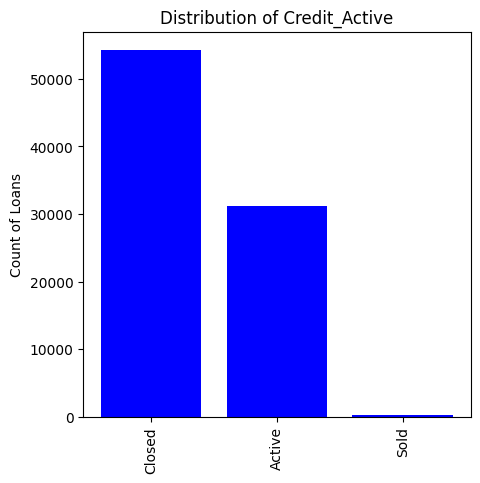

In [280]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
status_dict = dict(credit_active_counter)
sorted_status_dict = dict(sorted(status_dict.items(), key=lambda kv: kv[1], reverse=True))


ind = np.arange(len(sorted_status_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind, list(sorted_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Credit_Active')
plt.xticks(ind, list(sorted_status_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* Most of the applications in the Bureau Data are closed, which is followed by the status being Active.
* There are very few loans that are 'Sold' or considered to be 'Bad Debt'.

### 5.2.2 Univariate Analysis: Days_Credit

The Days_Credit Column refers to the length of time (in days) before the application that the client applied for Bureau Credit.

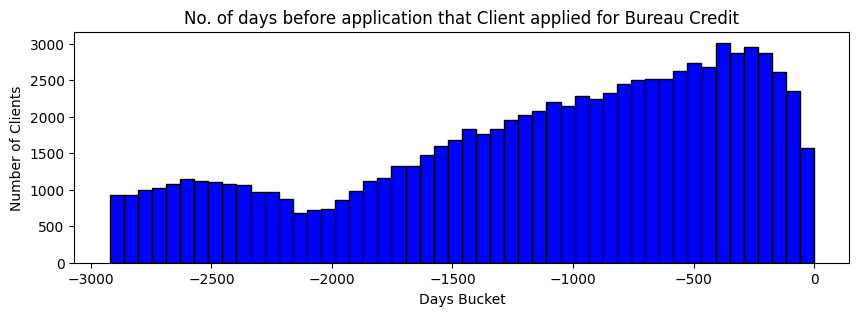

In [281]:
plt.figure(figsize=(10,3))
plt.hist(bureau_data['DAYS_CREDIT'].values, bins=50, edgecolor='black', color='blue')
plt.title('No. of days before application that Client applied for Bureau Credit')
plt.xlabel('Days Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* Most of the clients applied for Bureau Credit less than 500 days before the date of loan application.

### 5.2.3 Univariate Analysis: Credit_Day_Overdue

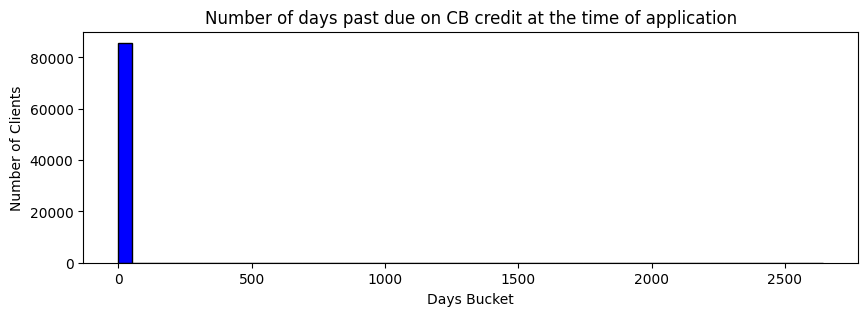

In [282]:
plt.figure(figsize=(10,3))
plt.hist(bureau_data['CREDIT_DAY_OVERDUE'].values, bins=50, edgecolor='black', color='blue')
plt.title('Number of days past due on CB credit at the time of application')
plt.xlabel('Days Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Note : </h4> 
    
This shows that most of the clients have a low DPD (close to 0) on CB Credit at the Time of their application since the histogram is very peaked near 0. To analyse this further, we will have a look at the respective percentile values as shown below.  

In [283]:
y = PrettyTable()
y.field_names = ["Percentile", "No. of days past due on CB Credit"]

for i in range(0,101,10):
    y.add_row([i,np.percentile(bureau_data['CREDIT_DAY_OVERDUE'].values,i)])
print(y)

+------------+-----------------------------------+
| Percentile | No. of days past due on CB Credit |
+------------+-----------------------------------+
|     0      |                0.0                |
|     10     |                0.0                |
|     20     |                0.0                |
|     30     |                0.0                |
|     40     |                0.0                |
|     50     |                0.0                |
|     60     |                0.0                |
|     70     |                0.0                |
|     80     |                0.0                |
|     90     |                0.0                |
|    100     |               2643.0              |
+------------+-----------------------------------+


<h4> Observations : </h4>

* There is 0 DPD till the 90th percentile as well, whereas the 100th percentile is a value = 2792.
* We will further zoom into the values between the 99th and 100th percentiles.

In [284]:
z = PrettyTable()
z.field_names = ["Percentile", "No. of days past due on CB Credit"]

for i in np.arange(99,100,0.1):
    z.add_row(np.round([i,np.percentile(bureau_data['CREDIT_DAY_OVERDUE'].values,i)],2))
print(z)

+------------+-----------------------------------+
| Percentile | No. of days past due on CB Credit |
+------------+-----------------------------------+
|    99.0    |                0.0                |
|    99.1    |                0.0                |
|    99.2    |                0.0                |
|    99.3    |                0.0                |
|    99.4    |                0.0                |
|    99.5    |                0.0                |
|    99.6    |                0.0                |
|    99.7    |                0.0                |
|    99.8    |                9.36               |
|    99.9    |                60.0               |
+------------+-----------------------------------+


<h4> Observations : </h4>

* We can see from here that only the Top 0.3 percentile of values over here are non-zeroes.

In [285]:
bureau_data[bureau_data['CREDIT_DAY_OVERDUE']>0].shape[0]
#This basically shows that there are a total of 4217 datapoints where the 'Credit_Day_Overdue' value is greater
#than 0.

188

### 5.2.4 Univariate Analysis: Credit_Type

In [286]:
credit_type_counter = Counter()
for type in bureau_data['CREDIT_TYPE'].values:
    credit_type_counter.update(type.split(','))

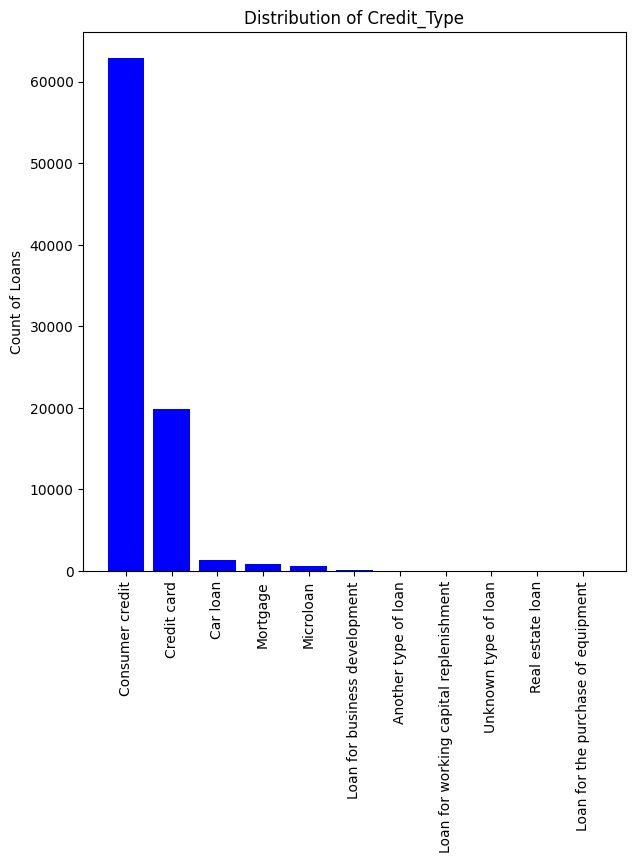

In [287]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
type_dict = dict(credit_type_counter)
sorted_type_dict = dict(sorted(type_dict.items(), key=lambda kv: kv[1], reverse=True))

ind_2 = np.arange(len(sorted_type_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_2, list(sorted_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Credit_Type')
plt.xticks(ind_2, list(sorted_type_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* Consumer Credit and Credit Cards are the mostly registered credit types in the Credit Bureau.

### 5.2.5 Bivariate Analysis: Credit_Active vs Days_Credit

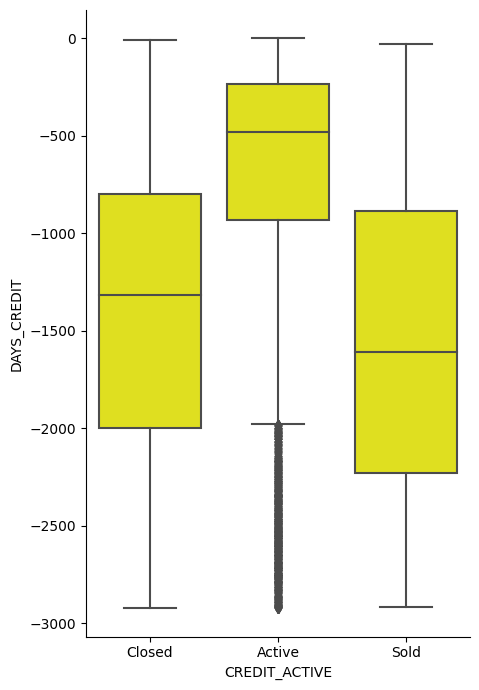

In [288]:
sns.catplot(x="CREDIT_ACTIVE", y="DAYS_CREDIT",\
            data=bureau_data,color = "yellow",kind="box", height=7, aspect=.7);

<h4> Observations : </h4>

* When the Credit Status is Active, it means that the corresponding 'Days_Credit' ie. number of days before Application, the median value is approx. 500 days.

<h2>5.3. Basic Overview of the Bureau Balance Data </h2>

In [289]:
bureau_balance = reduce_memory_usage(pd.read_csv('../data/home-credit-default-risk/bureau_balance.csv'))
rows_to_keep = int(len(bureau_balance) * reduce_ratio)
bureau_balance = bureau_balance.sample(n=rows_to_keep, random_state=42)
print('Number of data points : ', bureau_balance.shape[0])
print('Number of features : ', bureau_balance.shape[1])
bureau_balance.head()

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Number of data points :  1364996
Number of features :  3


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10077170,6423524,-10,X
15189524,6059583,-20,0
6921920,6298033,-70,C
2380938,6562465,-2,0
21676529,5929260,-31,C


In [290]:
bureau_balance.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

<h2> 5.4. Bureau Balance Data Analysis </h2>

### 5.4.1 Univariate Analysis: Status

In [291]:
bureau_status_counter = Counter()
for status in bureau_balance['STATUS'].values:
    bureau_status_counter.update(status.split(','))

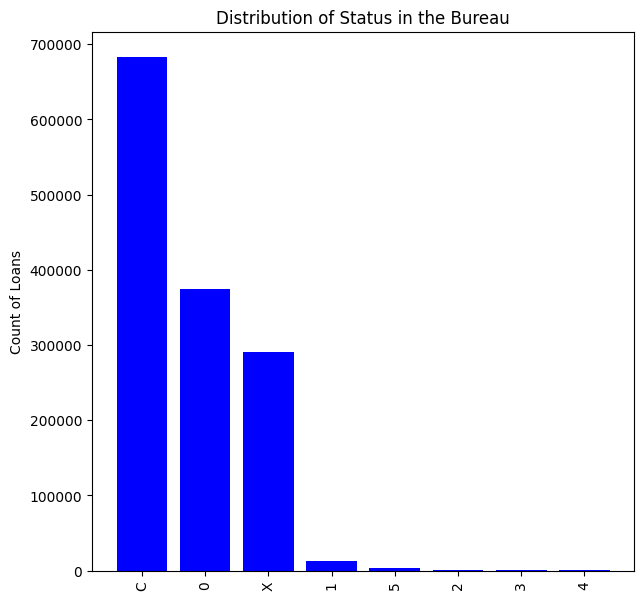

In [292]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
status_dict = dict(bureau_status_counter)
sorted_status_dict = dict(sorted(status_dict.items(), key=lambda kv: kv[1], reverse=True))


ind_3 = np.arange(len(sorted_status_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_3, list(sorted_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Status in the Bureau')
plt.xticks(ind_3, list(sorted_status_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* Most of the loans are Closed in the Credit Bureau, which is followed by clients with 0 DPD and then by applicants whose status is unknown.
* We can conclude that there are very few annuity defaulters in the data.

<h2> 5.5 Feature Engineering on Bureau Data and Bureau Balance Data </h2>

In [293]:
def generate_credit_type_code(x):
    if x == 'Closed':
        y = 0
    elif x=='Active':
        y = 1
    else:
        y = 2    
    return y


def FE_bureau_data_1(bureau_data):

    bureau_data['CREDIT_DURATION'] = -bureau_data['DAYS_CREDIT'] + bureau_data['DAYS_CREDIT_ENDDATE'] 
    bureau_data['ENDDATE_DIFF'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_ENDDATE_FACT']
    bureau_data['UPDATE_DIFF'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_CREDIT_UPDATE']
    bureau_data['DEBT_PERCENTAGE'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_CREDIT_SUM_DEBT']
    bureau_data['DEBT_CREDIT_DIFF'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data['AMT_CREDIT_SUM_DEBT']
    bureau_data['CREDIT_TO_ANNUITY_RATIO'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_ANNUITY']
    bureau_data['DEBT_TO_ANNUITY_RATIO'] = bureau_data['AMT_CREDIT_SUM_DEBT'] / bureau_data['AMT_ANNUITY']
    bureau_data['CREDIT_OVERDUE_DIFF'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data['AMT_CREDIT_SUM_OVERDUE']
    
    #Refer :- https://www.kaggle.com/c/home-credit-default-risk/discussion/57750
    #Calculating the Number of Past Loans for each Customer
    no_loans_per_customer = bureau_data[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby(by = \
                                                                    ['SK_ID_CURR'])['SK_ID_BUREAU'].count()
    no_loans_per_customer = no_loans_per_customer.reset_index().rename(columns={'SK_ID_BUREAU': 'CUSTOMER_LOAN_COUNT'})
    bureau_data = bureau_data.merge(no_loans_per_customer, on='SK_ID_CURR', how='left')
    
    #Calculating the Past Credit Types per Customer
    credit_types_per_customer = bureau_data[['SK_ID_CURR','CREDIT_TYPE']].groupby(by=['SK_ID_CURR'])['CREDIT_TYPE'].nunique()
    credit_types_per_customer = credit_types_per_customer.reset_index().rename(columns={'CREDIT_TYPE':'CUSTOMER_CREDIT_TYPES'})
    bureau_data = bureau_data.merge(credit_types_per_customer, on='SK_ID_CURR',how='left')
    
    #Average Loan Type per Customer
    bureau_data['AVG_LOAN_TYPE'] = bureau_data['CUSTOMER_LOAN_COUNT']/bureau_data['CUSTOMER_CREDIT_TYPES']
    
    bureau_data['CREDIT_TYPE_CODE'] = bureau_data.apply(lambda x:\
                                        generate_credit_type_code(x.CREDIT_ACTIVE), axis=1)
    
    customer_credit_code_mean = bureau_data[['SK_ID_CURR','CREDIT_TYPE_CODE']].groupby(by=['SK_ID_CURR'])['CREDIT_TYPE_CODE'].mean()
    customer_credit_code_mean.reset_index().rename(columns={'CREDIT_TYPE_CODE':'CUSTOMER_CREDIT_CODE_MEAN'})
    bureau_data = bureau_data.merge(customer_credit_code_mean, on='SK_ID_CURR', how='left')
    
    #Computing the Ratio of Total Customer Credit and the Total Customer Debt
    bureau_data['AMT_CREDIT_SUM'] = bureau_data['AMT_CREDIT_SUM'].fillna(0)
    bureau_data['AMT_CREDIT_SUM_DEBT'] = bureau_data['AMT_CREDIT_SUM_DEBT'].fillna(0)
    bureau_data['AMT_ANNUITY'] = bureau_data['AMT_ANNUITY'].fillna(0)
    
    credit_sum_customer = bureau_data[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=\
                                                                            ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum()
    credit_sum_customer = credit_sum_customer.reset_index().rename(columns={'AMT_CREDIT_SUM':'TOTAL_CREDIT_SUM'})
    bureau_data = bureau_data.merge(credit_sum_customer, on='SK_ID_CURR', how='left')
                                      
    credit_debt_sum_customer = bureau_data[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=\
                                                                        ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum()
    credit_debt_sum_customer = credit_debt_sum_customer.reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_DEBT_SUM'})
    bureau_data = bureau_data.merge(credit_debt_sum_customer, on='SK_ID_CURR', how='left')
    bureau_data['CREDIT_DEBT_RATIO'] = bureau_data['TOTAL_CREDIT_SUM']/bureau_data['TOTAL_DEBT_SUM']
    
    return bureau_data
    

In [294]:
bureau_data_fe = FE_bureau_data_1(bureau_data)

#One Hot Encoding the Bureau Datasets
bureau_data, bureau_data_columns = one_hot_encode(bureau_data_fe)
bureau_balance, bureau_balance_columns = one_hot_encode(bureau_balance)

In [295]:
def FE_bureau_data_2(bureau_data,bureau_balance,bureau_data_columns,bureau_balance_columns):

    bureau_balance_agg = {'MONTHS_BALANCE': ['min','max','mean','size']}
    
    for column in bureau_balance_columns:
        bureau_balance_agg[column] = ['min','max','mean','size']
        bureau_balance_final_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_agg)
    
    col_list_1 =[]
    
    for col in bureau_balance_final_agg.columns.tolist():
        col_list_1.append(col[0] + "_" + col[1].upper())
    
    bureau_balance_final_agg.columns = pd.Index(col_list_1)
    bureau_data_balance = bureau_data.join(bureau_balance_final_agg, how='left', on='SK_ID_BUREAU')
    bureau_data_balance.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

    del bureau_balance_final_agg
    gc.collect()


    numerical_agg = {'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],'AMT_CREDIT_SUM_OVERDUE': ['mean','sum'],
        'DAYS_CREDIT': ['mean', 'var'],'DAYS_CREDIT_UPDATE': ['mean','min'],'CREDIT_DAY_OVERDUE': ['mean','min'],
        'DAYS_CREDIT_ENDDATE': ['mean'],'CNT_CREDIT_PROLONG': ['sum'],'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],'AMT_CREDIT_MAX_OVERDUE': ['mean','max'],
        'AMT_ANNUITY': ['max', 'mean','sum'],'AMT_CREDIT_SUM': ['mean', 'sum','max']
      }
    categorical_agg = {}

    for col in bureau_data_columns:
        categorical_agg[col] = ['mean']
        categorical_agg[col] = ['max']

    for col in bureau_balance_columns:
        categorical_agg[col + "_MEAN"] = ['mean']
        categorical_agg[col + "_MIN"] = ['min']
        categorical_agg[col + "_MAX"] = ['max']
    
    bureau_data_balance_2 = bureau_data_balance.groupby('SK_ID_CURR').agg({**numerical_agg,\
                                                                       **categorical_agg})
    col_list_2=[]
    
    for col in bureau_data_balance_2.columns.tolist():
        col_list_2.append('BUREAU_'+col[0]+'_'+col[1])
    bureau_data_balance_2.columns = pd.Index(col_list_2)   


    bureau_data_balance_3 = bureau_data_balance[bureau_data_balance['CREDIT_ACTIVE_Active'] == 1]
    bureau_data_balance_3_agg = bureau_data_balance_3.groupby('SK_ID_CURR').agg(numerical_agg)

    col_list_3=[]
    for col in bureau_data_balance_3_agg.columns.tolist():
        col_list_3.append('A_'+col[0]+'_'+col[1].upper())

    bureau_data_balance_3_agg.columns = pd.Index(col_list_3)
    b3_final = bureau_data_balance_2.join(bureau_data_balance_3_agg, how='left', \
                                      on='SK_ID_CURR')

    bureau_data_balance_4 = bureau_data_balance[bureau_data_balance['CREDIT_ACTIVE_Closed'] == 1]
    bureau_data_balance_4_agg = bureau_data_balance_4.groupby('SK_ID_CURR').agg(numerical_agg)
    col_list_4 =[]
    
    for col in bureau_data_balance_4_agg.columns.tolist():
        col_list_4.append('C_'+col[0]+'_'+col[1].upper())

    bureau_data_balance_4_agg.columns = pd.Index(col_list_4)
    bureau_data_balance_final = bureau_data_balance_2.join(bureau_data_balance_4_agg, \
                                                    how='left', on='SK_ID_CURR')

    del bureau_data_balance_3, bureau_data_balance_4_agg
    gc.collect()
    
    return bureau_data_balance_final

In [296]:
bureau_data_balance_final = FE_bureau_data_2(bureau_data, bureau_balance,bureau_data_columns,\
                                             bureau_balance_columns)
train_data_temp_2 = train_data_temp_1.join(bureau_data_balance_final, how='left', \
                                         on='SK_ID_CURR')

del bureau_data_balance_final
gc.collect()

train_data_temp_2.shape

(15375, 345)

<h1> 6. Previous Application Dataset </h1>

<h2>6.1. Basic Overview of the Train Data </h2>

In [297]:
previous_application = reduce_memory_usage(pd.read_csv('../data/home-credit-default-risk/previous_application.csv'))
rows_to_keep = int(len(previous_application) * reduce_ratio)
previous_application = previous_application.sample(n=rows_to_keep, random_state=42)
print('Number of data points : ', previous_application.shape[0])
print('Number of features : ', previous_application.shape[1])
previous_application.head()

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Number of data points :  83510
Number of features :  37


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
876718,1327604,127360,Consumer loans,5318.100098,27616.5,26082.0,2763.0,27616.5,WEDNESDAY,10,...,Consumer electronics,6.0,high,POS household with interest,365243.0,-1174.0,-1024.0,-1024.0,-1017.0,0.0
1463966,1830718,218834,Cash loans,19737.945312,135000.0,165226.5,NaN,135000.0,WEDNESDAY,8,...,XNA,12.0,high,Cash Street: high,365243.0,-1193.0,-863.0,-863.0,-855.0,1.0
354631,1258084,104079,Consumer loans,3304.709961,36184.5,32562.0,3622.5,36184.5,FRIDAY,11,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-574.0,-244.0,-574.0,-569.0,0.0
408441,2257201,389250,Consumer loans,10912.544922,240948.0,240948.0,0.0,240948.0,SATURDAY,9,...,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-724.0,-34.0,-34.0,-26.0,0.0
37031,1038283,385546,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,13,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [298]:
previous_application.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

<h2> 6.2 Previous Application Data Analysis </h2>

### 6.2.1 Univariate Analysis: Name_Cash_Loan_Purpose

In [299]:
application_loan_purpose = Counter()
for purpose in previous_application['NAME_CASH_LOAN_PURPOSE'].values:
    application_loan_purpose.update(purpose.split(','))

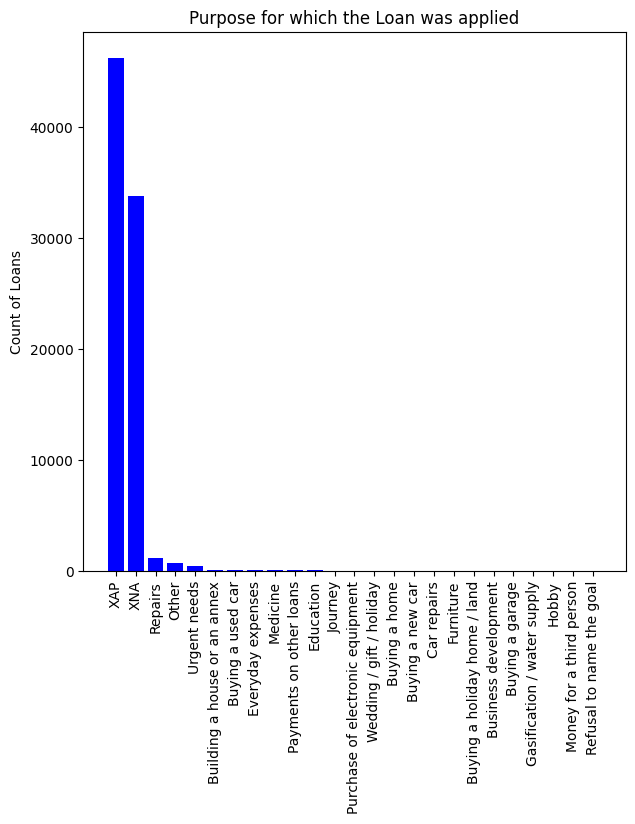

In [300]:
purpose_dict = dict(application_loan_purpose)
sorted_purpose_dict = dict(sorted(purpose_dict.items(), key=lambda kv: kv[1], reverse=True))

ind_4 = np.arange(len(sorted_purpose_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_4, list(sorted_purpose_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Purpose for which the Loan was applied')
plt.xticks(ind_4, list(sorted_purpose_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* The purpose for most of the Loan Applications is XAP, which is followed by XNA. However, the definition of these terms is not provided in the columns_description.csv.
* This may mean that the loan application purpose was not shared by the applicant, though we cannot be sure.

### 6.2.2 Univariate Analysis: Name_Contract_Status

In [301]:
application_contract_status = Counter()
for status in previous_application['NAME_CONTRACT_STATUS'].values:
    application_contract_status.update(status.split(','))

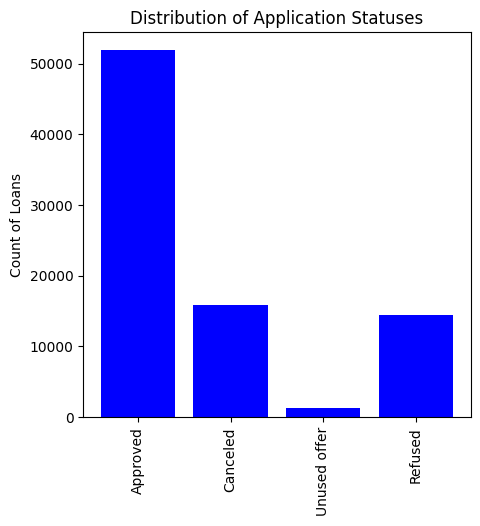

In [302]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
contract_status_dict = dict(application_contract_status)
sorted_contract_status_dict = dict(sorted(contract_status_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_5 = np.arange(len(contract_status_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_5, list(contract_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Application Statuses')
plt.xticks(ind_5, list(contract_status_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* Most of the previous applications for the clients were approved.
* This is followed by applications that were cancelled and refused.
* There were very few applications that were approved but the loans were unused by the applicant.

### 6.2.3 Univariate Analysis: Name_Payment_Type

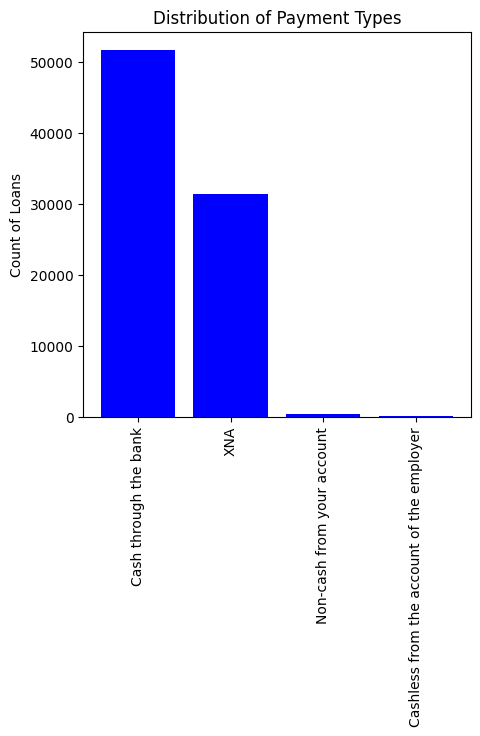

In [303]:
application_payment_type = Counter()
for type in previous_application['NAME_PAYMENT_TYPE'].values:
    application_payment_type.update(type.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
payment_type_dict = dict(application_payment_type)
sorted_payment_type_dict = dict(sorted(payment_type_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_6 = np.arange(len(payment_type_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_6, list(payment_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Payment Types')
plt.xticks(ind_6, list(payment_type_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* The Payment Type basically refers to the Payment Method that the client chose to pay for the previous application, and as we can see here, most of the clients chose to pay via Cash through the Bank for the same.
* This is followed by people whose payment type is XNA.

### 6.2.4 Univariate Analysis: Code_Reject_Reason

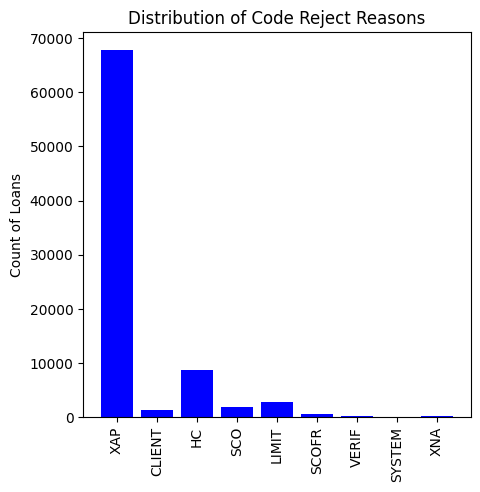

In [304]:
application_code_reject_reason = Counter()
for reason in previous_application['CODE_REJECT_REASON'].values:
    application_code_reject_reason.update(reason.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
code_reject_reason_dict = dict(application_code_reject_reason)
sorted_code_reject_reason_dict = dict(sorted(code_reject_reason_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_7 = np.arange(len(code_reject_reason_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_7, list(code_reject_reason_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Code Reject Reasons')
plt.xticks(ind_7, list(code_reject_reason_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* Code_Reject_Reason basically refers to the reason why the previous loan application of the client was rejected by the bank. As can be seen from here, in most of the cases XAP, was the reason provided. (Not Applicable)
* This is followed by HC as the second most prominent reason.

### 6.2.5 Univariate Analysis: Name_Client_Type

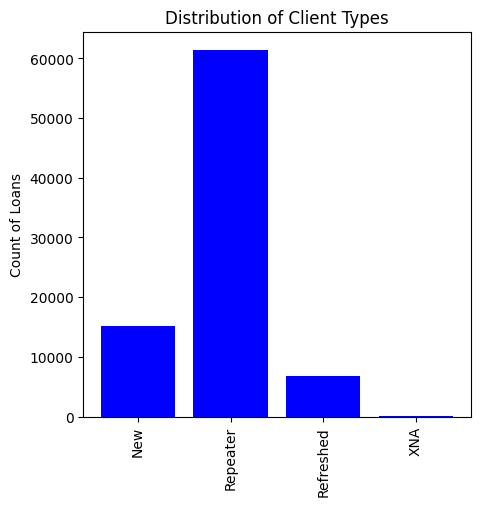

In [305]:
application_client_type = Counter()
for type in previous_application['NAME_CLIENT_TYPE'].values:
    application_client_type.update(type.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
client_type_dict = dict(application_client_type)
sorted_client_type_dict = dict(sorted(client_type_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_8 = np.arange(len(client_type_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_8, list(client_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Client Types')
plt.xticks(ind_8, list(client_type_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* This particular column defines whether the client was old or new when he/she was applying for the previous application. We can see from here that most of the applicants for the previous application were repeaters and there were very few first time applicants.

### 6.2.6 Univariate Analysis: Name_Goods_Category

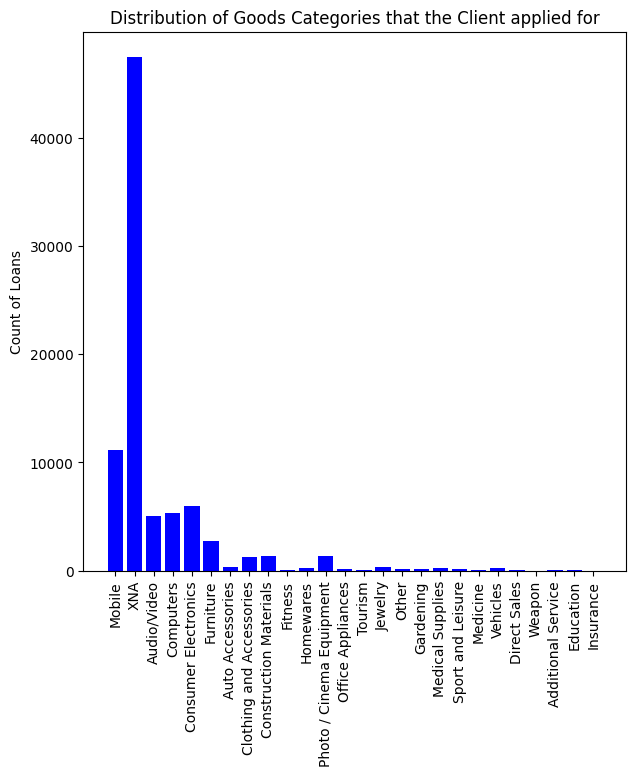

In [306]:
application_goods_category = Counter()
for category in previous_application['NAME_GOODS_CATEGORY'].values:
    application_goods_category.update(category.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
goods_category_dict = dict(application_goods_category)
sorted_goods_category = dict(sorted(goods_category_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_9 = np.arange(len(goods_category_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_9, list(goods_category_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Goods Categories that the Client applied for')
plt.xticks(ind_9, list(goods_category_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* This defines the kind of goods that the client applied for in the previous application, and as can be seen, XNA is the most popular goods category followed by Mobiles.

### 6.2.7 Univariate Analysis: Name_Portfolio

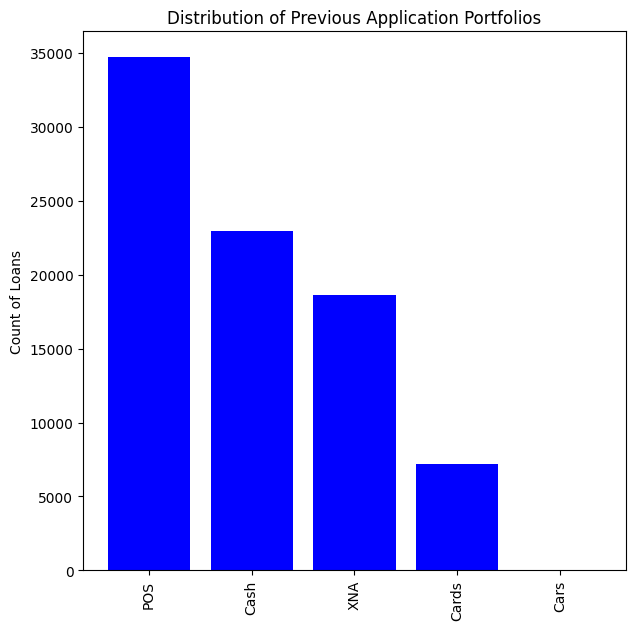

In [307]:
application_name_portfolio = Counter()
for name in previous_application['NAME_PORTFOLIO'].values:
    application_name_portfolio.update(name.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
application_name_dict = dict(application_name_portfolio)
sorted_name_portfolio = dict(sorted(application_name_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_10 = np.arange(len(application_name_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_10, list(application_name_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Previous Application Portfolios')
plt.xticks(ind_10, list(application_name_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* This shows that most of the previous applications were for POS, which is followed by Cash and XNA.

### 6.2.8 Univariate Analysis: Channel_Type

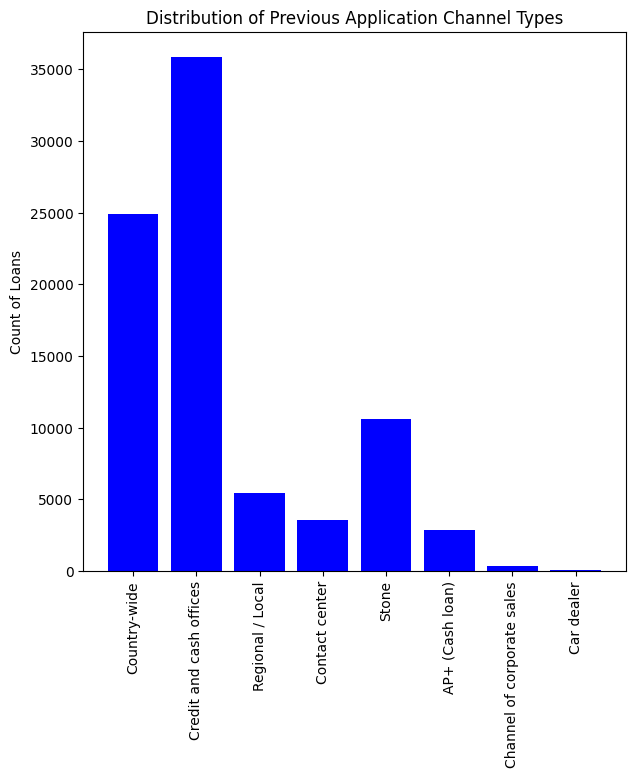

In [308]:
application_channel_type = Counter()
for type in previous_application['CHANNEL_TYPE'].values:
    application_channel_type.update(type.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
channel_type_dict = dict(application_channel_type)
sorted_channel_type = dict(sorted(application_channel_type.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_11 = np.arange(len(channel_type_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_11, list(channel_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Previous Application Channel Types')
plt.xticks(ind_11, list(channel_type_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* This shows that the banks obtained most of the clients in their previous application through Credit and Cash offices, which is followed by Country-wide.

### 6.2.9 Univariate Analysis: Nflag_Insured_on_Approval

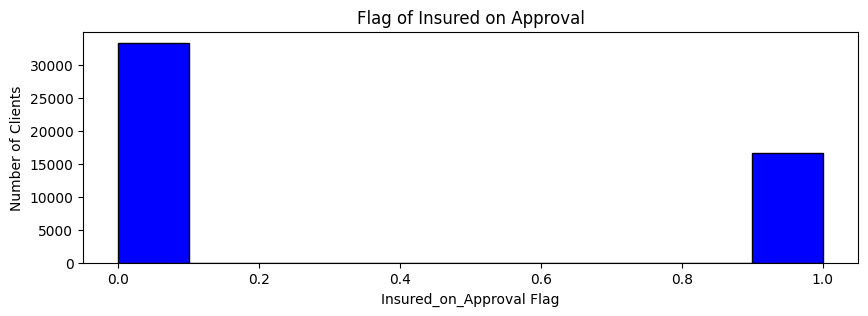

In [309]:
plt.figure(figsize=(10,3))
plt.hist(previous_application['NFLAG_INSURED_ON_APPROVAL'].values, bins=10, \
         edgecolor='black', color='blue')
plt.title('Flag of Insured on Approval')
plt.xlabel('Insured_on_Approval Flag')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* There are much fewer clients who applied for Insurance in the previous application as compared to the number of clients who did not apply for insurance.

<h2> 6.3 Dealing with Null Values and Outliers </h2>

We won't be able to find outliers for Amount and Cash related features except that these values cannot be negative. Except these, we will try and deal with the remaining features.

<h3> 6.3.1 Days_Decision </h3>

This feature basically refers to the number of days relative to the current application that the decision made about the previous application.

In [310]:
previous_application['DAYS_DECISION'].describe()

count    83510.000000
mean      -880.083224
std        779.671436
min      -2922.000000
25%      -1300.000000
50%       -581.000000
75%       -280.000000
max         -1.000000
Name: DAYS_DECISION, dtype: float64

In [311]:
print("The maximum Days_Decision (in years) across all applications = ",\
      - min(previous_application['DAYS_DECISION'].values)/365)

print("The minimum Days_Decision (in years) across all applications = ",\
      - max(previous_application['DAYS_DECISION'].values)/365)

The maximum Days_Decision (in years) across all applications =  8.005479452054795
The minimum Days_Decision (in years) across all applications =  0.0027397260273972603


<h4> Observations : </h4>

* This basically means that both the minimum as well as the maxium ages are admissible and there are no outliers present in the 'Days_Decision' column.

<h3> 6.3.2 Days_First_Drawing </h3>

This feature means that relative to application date of the current application when was the first disbursement of the previous application carried out.

In [312]:
previous_application['DAYS_FIRST_DRAWING'].describe()

count     49883.000000
mean     343039.843750
std       87402.835938
min       -2914.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

In [313]:
print("The maximum Days_First_Drawing (in years) across all applications = ",\
       max(previous_application['DAYS_FIRST_DRAWING'].values)/365)

print("The minimum Days_First_Drawing (in years) across all applications = ",\
       min(previous_application['DAYS_FIRST_DRAWING'].values)/365)

The maximum Days_First_Drawing (in years) across all applications =  1000.6657534246575
The minimum Days_First_Drawing (in years) across all applications =  -7.983561643835617


<h4> Note </h4>

This basically means that the maximum Days_First_Drawing in the table is 1000 years before the current application, which is obviously impossible. Also, since the 25th, 50th, and 75th Percentile values of this feature is the same as the maximum value across all features, we will first deal with removing this maximum value.

In [314]:
previous_application['DAYS_FIRST_DRAWING'].replace(max(previous_application['DAYS_FIRST_DRAWING'].values),\
                                                  np.nan, inplace=True)

In [315]:
previous_application['DAYS_FIRST_DRAWING'].describe()

count    3024.000000
mean    -1013.146851
std       905.791992
min     -2914.000000
25%     -1402.750000
50%      -610.000000
75%      -308.000000
max        -2.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

<h4> Observations : </h4>

* Now we can see that both the minimum as well as maximum values across Days_First_Drawing are admissible (both are negative with respect to the current application).

<h3> 6.3.3 Days_First_Due </h3>

Days_First_Due means that relative to application date of current application when was the first due supposed to be of the previous application. 

In [316]:
previous_application['DAYS_FIRST_DUE'].describe()

count     49883.000000
mean      14029.339844
std       72916.421875
min       -2891.000000
25%       -1622.000000
50%        -834.000000
75%        -413.000000
max      365243.000000
Name: DAYS_FIRST_DUE, dtype: float64

In [317]:
previous_application['DAYS_FIRST_DUE'].replace(np.nan,0, inplace= True)

print("The minimum Days_First_Due (in years) across all applications = ",\
       min(previous_application['DAYS_FIRST_DUE'].values)/365)

print("The maximum Days_First_Due (in years) across all applications = ",\
       max(previous_application['DAYS_FIRST_DUE'].values)/365)

previous_application['DAYS_FIRST_DUE'].replace(0,np.nan, inplace= True)

The minimum Days_First_Due (in years) across all applications =  -7.920547945205479
The maximum Days_First_Due (in years) across all applications =  1000.6657534246575


<h4> Note </h4>

This basically means that the maximum Days_First_Due in the table is 1000 years before the current application, which is obviously impossible. So we will first deal with removing this maximum value in this feature.

In [318]:
previous_application['DAYS_FIRST_DUE'].replace(max(previous_application['DAYS_FIRST_DUE'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_FIRST_DUE'].describe()

count    47822.000000
mean     -1107.026367
std        790.154480
min      -2891.000000
25%      -1673.000000
50%       -876.000000
75%       -461.000000
max         -3.000000
Name: DAYS_FIRST_DUE, dtype: float64

<h4> Observations : </h4>

* Now we can see that both the minimum as well as maximum values across Days_First_Due are admissible (both are negative with respect to the current application).

<h3> 6.3.4 Days_Last_Due_1st_Version </h3>

This feature means that relative to application date of the current application, when was the first due of the previous application.

In [319]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].describe()

count     49883.000000
mean      33078.867188
std      105897.906250
min       -2800.000000
25%       -1239.500000
50%        -365.000000
75%         122.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

In [320]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(np.nan,0, inplace= True)

print("The minimum Days_Last_Due_1st_Version (in years) across all applications = ",\
       np.round(min(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values)/365,3))

print("The maximum Days_Last_Due_1st_Version (in years) across all applications = ",\
       np.round(max(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values)/365,3))

previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(0,np.nan, inplace= True)

The minimum Days_Last_Due_1st_Version (in years) across all applications =  -7.671
The maximum Days_Last_Due_1st_Version (in years) across all applications =  1000.666


<h4> Note </h4>

Again, this means that the maximum Days_Last_Due_1st_Version in the table is 1000 years before the current application, which is obviously impossible. So we will first deal with removing this maximum value in this feature.

In [321]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(max(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].describe()

count    45247.000000
mean      -680.160828
std        923.363770
min      -2800.000000
25%      -1360.000000
50%       -485.000000
75%         -3.000000
max       2011.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

<h4> Observations : </h4>

* Again, we can see that both the minimum as well as maximum values across Days_Last_Due_1st_Version are admissible (both are negative with respect to the current application).

<h3> 6.3.5 Days_Last_Due </h3>

Days_Last_Due means that relative to the application date of the current application, when was the last due date of the previous application.

In [322]:
previous_application['DAYS_LAST_DUE'].describe()

count     49883.000000
mean      76723.843750
std      149750.953125
min       -2884.000000
25%       -1308.000000
50%        -542.000000
75%         -74.500000
max      365243.000000
Name: DAYS_LAST_DUE, dtype: float64

In [323]:
previous_application['DAYS_LAST_DUE'].replace(np.nan,0, inplace= True)

print("The minimum Days_Last_Due (in years) across all applications = ",\
       np.round(min(previous_application['DAYS_LAST_DUE'].values)/365,3))

print("The maximum Days_Last_Due (in years) across all applications = ",\
       np.round(max(previous_application['DAYS_LAST_DUE'].values)/365,3))

previous_application['DAYS_LAST_DUE'].replace(0,np.nan, inplace= True)

The minimum Days_Last_Due (in years) across all applications =  -7.901
The maximum Days_Last_Due (in years) across all applications =  1000.666


<h4> Note </h4>

This means that the maximum Days_Last_Due in the table is 1000 years before the current application, which is impossible. So we will first deal with removing this maximum value in this feature.

In [324]:
previous_application['DAYS_LAST_DUE'].replace(max(previous_application['DAYS_LAST_DUE'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_LAST_DUE'].describe()

count    39297.000000
mean      -998.729065
std        753.893250
min      -2884.000000
25%      -1567.000000
50%       -803.000000
75%       -356.000000
max         -3.000000
Name: DAYS_LAST_DUE, dtype: float64

<h4> Observations : </h4>

* We can see here that both the minimum as well as maximum values across Days_Last_Due are admissible (both are negative with respect to the current application).

<h3> 6.3.6 Days_Termination </h3>

Days_Termination means that relative to the application date of the current application, when was the expected termination of the previous application.

In [325]:
previous_application['DAYS_TERMINATION'].describe()

count     49883.000000
mean      82110.820312
std      153386.031250
min       -2839.000000
25%       -1266.500000
50%        -506.000000
75%         -44.000000
max      365243.000000
Name: DAYS_TERMINATION, dtype: float64

In [326]:
previous_application['DAYS_TERMINATION'].replace(np.nan,0, inplace= True)

print("The minimum Days_Termination (in years) across all applications = ",\
       np.round(min(previous_application['DAYS_TERMINATION'].values)/365,3))

print("The maximum Days_Termination (in years) across all applications = ",\
       np.round(max(previous_application['DAYS_TERMINATION'].values)/365,3))

previous_application['DAYS_TERMINATION'].replace(0,np.nan, inplace= True)

The minimum Days_Termination (in years) across all applications =  -7.778
The maximum Days_Termination (in years) across all applications =  1000.666


<h4> Note </h4>

This means that the maximum Days_Termination in the table is 1000 years before the current application, which is impossible. So we will first deal with removing this maximum value in this feature.

In [327]:
previous_application['DAYS_TERMINATION'].replace(max(previous_application['DAYS_TERMINATION'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_TERMINATION'].describe()

count    38565.000000
mean      -982.407166
std        750.481445
min      -2839.000000
25%      -1542.000000
50%       -785.000000
75%       -340.000000
max         -2.000000
Name: DAYS_TERMINATION, dtype: float64

<h4> Observations : </h4>

* Both the minimum as well as maximum values across Days_Termination are admissible (both are negative with respect to the current application).

<h2> 6.4 Feature Engineering on Previous Application </h2>

<h4> Function to carry out Feature Engineering for Multiple features </h4>

In [328]:
def FE_previous_application(previous_application):
    
    prev_app, previous_application_columns = one_hot_encode(previous_application)
    
    prev_app['APPLICATION_CREDIT_DIFF'] = prev_app['AMT_APPLICATION'] - prev_app['AMT_CREDIT']
    prev_app['APPLICATION_CREDIT_RATIO'] = prev_app['AMT_APPLICATION'] / prev_app['AMT_CREDIT']
    prev_app['CREDIT_TO_ANNUITY_RATIO'] = prev_app['AMT_CREDIT']/prev_app['AMT_ANNUITY']
    prev_app['DOWN_PAYMENT_TO_CREDIT'] = prev_app['AMT_DOWN_PAYMENT'] / prev_app['AMT_CREDIT']

    total_payment = prev_app['AMT_ANNUITY'] * prev_app['CNT_PAYMENT']
    prev_app['SIMPLE_INTERESTS'] = (total_payment/prev_app['AMT_CREDIT'] - 1)/prev_app['CNT_PAYMENT']

    prev_app['DAYS_LAST_DUE_DIFF'] = prev_app['DAYS_LAST_DUE_1ST_VERSION'] - prev_app['DAYS_LAST_DUE']

    numerical_agg_prev = {'AMT_ANNUITY': ['max', 'mean'], 'AMT_APPLICATION': ['max','mean'],\
                     'AMT_CREDIT':['max','mean'], 'AMT_DOWN_PAYMENT': ['max','mean'],\
                      'AMT_GOODS_PRICE':['mean','sum'], 'HOUR_APPR_PROCESS_START' :\
                      ['max','mean'], 'RATE_DOWN_PAYMENT':['max','mean'], 'RATE_INTEREST_PRIMARY':\
                      ['max','mean'],'RATE_INTEREST_PRIVILEGED':['max','mean'], \
                      'DAYS_DECISION': ['max','mean'], 'CNT_PAYMENT' :['mean','sum'], \
                      'DAYS_FIRST_DRAWING': ['max','mean'], 'DAYS_TERMINATION' : ['max','mean'],\
                      'APPLICATION_CREDIT_RATIO': ['max','mean'], 'DOWN_PAYMENT_TO_CREDIT' : \
                      ['max','mean'], 'DAYS_LAST_DUE_DIFF': ['max','mean']}

    categorical_agg_prev = {}
    
    for column in previous_application_columns:
        categorical_agg_prev[column] = ['mean']
    
    prev_app_agg1 = prev_app.groupby('SK_ID_CURR').agg({**numerical_agg_prev, \
                                                    **categorical_agg_prev})
    col_list_5 =[]
    
    for col in prev_app_agg1.columns.tolist():
        col_list_5.append('PREV_'+col[0]+'_'+col[1].upper())

    prev_app_agg1.columns = pd.Index(col_list_5)
    
    prev_app_cs_approved = prev_app[prev_app['NAME_CONTRACT_STATUS_Approved']==1]
    prev_app_agg2 = prev_app_cs_approved.groupby('SK_ID_CURR').agg(numerical_agg_prev)

    col_list_6 = []

    for col in prev_app_agg2.columns.tolist():
        col_list_6.append('CS_APP_' + col[0] + '_' + col[1].upper())
    
    prev_app_agg2.columns = pd.Index(col_list_6)
    
    prev_app_agg1_join = prev_app_agg1.join(prev_app_agg2, how='left', on='SK_ID_CURR')

    prev_app_cs_refused = prev_app[prev_app['NAME_CONTRACT_STATUS_Refused']==1]
    prev_app_agg3 = prev_app_cs_refused.groupby('SK_ID_CURR').agg(numerical_agg_prev)
    
    col_list_7 =[]

    for col in prev_app_agg3.columns.tolist():
        col_list_7.append('CS_REF_' + col[0] + '_' + col[1].upper())

    prev_app_agg3.columns = pd.Index(col_list_7)
    prev_app_agg_final = prev_app_agg1_join.join(prev_app_agg3,how='left', on='SK_ID_CURR')
    
    del prev_app_agg1_join, prev_app_agg3, prev_app_cs_refused, prev_app_agg1, prev_app_agg2,\
        prev_app_cs_approved
    gc.collect()
    return prev_app_agg_final

<h4> Function to carry out Feature Engineering using 'Days_Decision' </h4>

In [329]:
def FE_previous_application_days_decision(data,data_temp,previous_application):
    
    temp_1 = FE_previous_application(reduce_memory_usage(previous_application))
    data = data_temp.merge(temp_1, how='left', on='SK_ID_CURR')
    del temp_1
    gc.collect()

    temp_2 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-365].reset_index())
    temp_2.drop(['index'], axis=1, inplace=True)
    temp_2 = FE_previous_application(temp_2)
    data = data.join(temp_2, how='left', on='SK_ID_CURR',rsuffix='_year')
    del temp_2
    gc.collect()

    temp_3 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-182].reset_index())
    temp_3.drop(['index'], axis=1, inplace=True)
    temp_3 = FE_previous_application(temp_3)
    data = data.join(temp_3, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_3
    gc.collect()

    temp_4 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-90].reset_index())
    temp_4.drop(['index'], axis=1, inplace=True)
    temp_4 = FE_previous_application(temp_4)
    data = data.join(temp_4, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_4
    gc.collect()

    temp_5 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-30].reset_index())
    temp_5.drop(['index'], axis=1, inplace=True)
    temp_5 = FE_previous_application(temp_5)
    data = data.join(temp_5, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_5
    gc.collect()

    temp_6 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-14].reset_index())
    temp_6.drop(['index'], axis=1, inplace=True)
    temp_6 = FE_previous_application(temp_6)
    data = data.join(temp_6, how='left', on='SK_ID_CURR', rsuffix='_fortnight')
    del temp_6
    gc.collect()

    temp_7 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-7].reset_index())
    temp_7.drop(['index'], axis=1, inplace=True)
    temp_7 = FE_previous_application(temp_7)
    data = data.join(temp_7, how='left', on='SK_ID_CURR', rsuffix='_week')
    del temp_7
    gc.collect()
    
    return data

<h4> Carrying out Feature Engineering using the Functions Defined </h4>

In [330]:
train_data_temp_2 = FE_previous_application_days_decision(train_data, train_data_temp_2,previous_application)
train_data_temp_2.shape

Memory usage of dataframe is 16.09 MB
Memory usage after optimization is: 15.29 MB
Decreased by 5.0%
Memory usage of dataframe is 5.28 MB
Memory usage after optimization is: 5.17 MB
Decreased by 2.1%
Memory usage of dataframe is 2.05 MB
Memory usage after optimization is: 2.01 MB
Decreased by 2.1%
Memory usage of dataframe is 0.82 MB
Memory usage after optimization is: 0.80 MB
Decreased by 2.6%
Memory usage of dataframe is 0.34 MB
Memory usage after optimization is: 0.33 MB
Decreased by 3.6%
Memory usage of dataframe is 0.16 MB
Memory usage after optimization is: 0.16 MB
Decreased by 3.6%
Memory usage of dataframe is 0.08 MB
Memory usage after optimization is: 0.09 MB
Decreased by -4.7%


(15375, 1976)

<h1> 7. POS Cash Balance Dataset </h1>

<h2>7.1. Basic Overview of the POS Cash Balance Data </h2>

In [331]:
pos_cash_balance = reduce_memory_usage(pd.read_csv('../data/home-credit-default-risk/POS_CASH_balance.csv'))
rows_to_keep = int(len(pos_cash_balance) * reduce_ratio)
pos_cash_balance = pos_cash_balance.sample(n=rows_to_keep, random_state=42)
print('Number of data points : ', pos_cash_balance.shape[0])
print('Number of features : ', pos_cash_balance.shape[1])
pos_cash_balance.head()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Number of data points :  500067
Number of features :  8


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
6385902,1141316,278001,-37,12.0,0.0,Completed,0,0
389847,2682740,248899,-67,12.0,4.0,Active,0,0
7302029,2136647,209965,-73,18.0,18.0,Active,0,0
6010681,1678541,432875,-8,24.0,16.0,Active,0,0
2031441,1870173,117636,-86,10.0,7.0,Active,0,0


In [332]:
pos_cash_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

<h2> 7.2 POS Cash Balance Data Analysis </h2>

### 7.2.1 Univariate Analysis : Months_Balance

Months_Balance refers to the Month of balance relative to the application date (0 could mean the same as -1 because as many banks are not updating the information to the Credit Bureau with regularity).

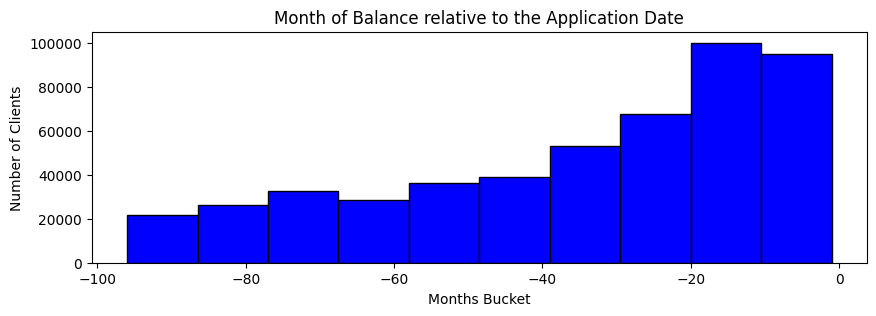

In [333]:
plt.figure(figsize=(10,3))
plt.hist(pos_cash_balance['MONTHS_BALANCE'].values, bins=10, edgecolor='black', color='blue')
plt.title('Month of Balance relative to the Application Date')
plt.xlabel('Months Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* The Months_Balance for a large number of the clients is between 10 and 20 months before the date of application.
* This is followed by clients with Months_Balance less than 10 months.

### 7.2.2 Univariate Analysis : Cnt_Instalment

Cnt_Installment refers to the term of the previous credit (which can change over the period of time).

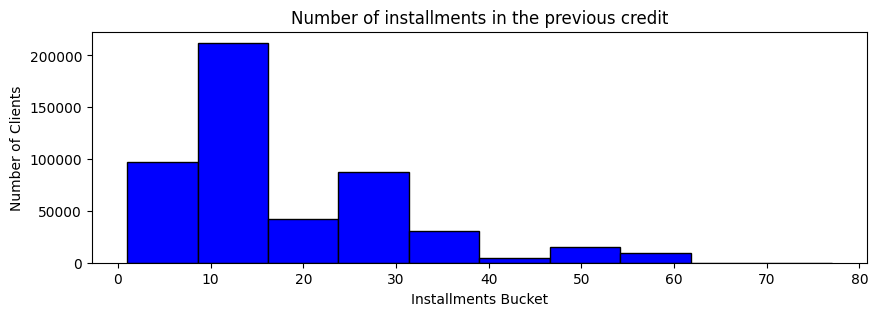

In [334]:
plt.figure(figsize=(10,3))
plt.hist(pos_cash_balance['CNT_INSTALMENT'].values, bins=10, edgecolor='black', color='blue')
plt.title('Number of installments in the previous credit')
plt.xlabel('Installments Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* The Number of installments in the previous credit for most clients lies between 10 and 20.
* This is followed by clients whose installment count is less than 10 months.

### 7.2.3 Univariate Analysis : Cnt_Instalment_Future

This feature refers to the number of installments left to pay on the previous credit.

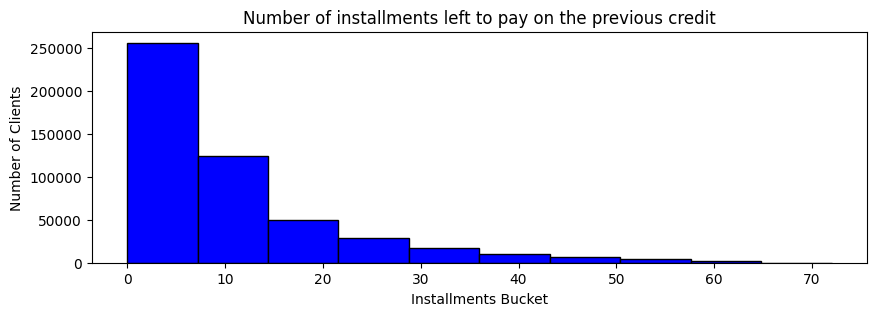

In [335]:
plt.figure(figsize=(10,3))
plt.hist(pos_cash_balance['CNT_INSTALMENT_FUTURE'].values, bins=10, edgecolor='black', color='blue')
plt.title('Number of installments left to pay on the previous credit')
plt.xlabel('Installments Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* Most of the clients have less than 10 installments left to pay on the previous credit.
* This is followed by clients whose installment count is between 10 and 20.

### 7.2.4 Univariate Analysis : Name_Contract_Status

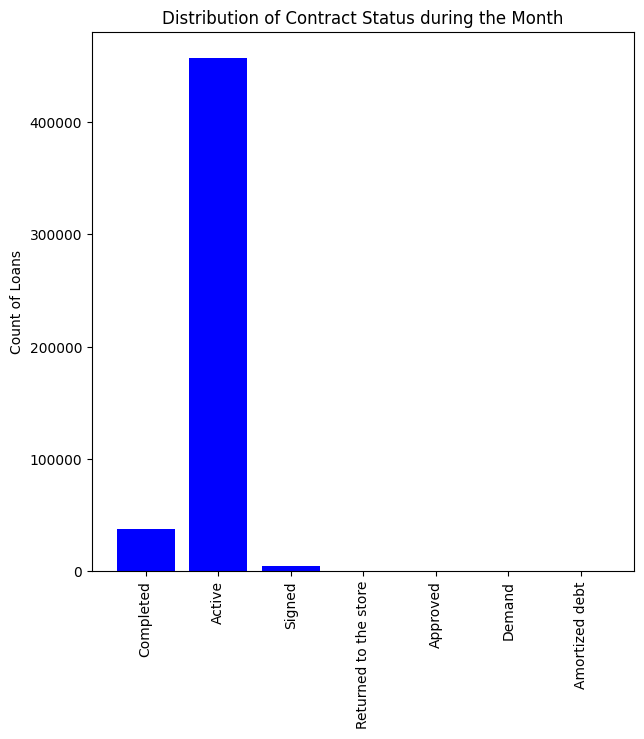

In [336]:
balance_contract_status = Counter()
for status in pos_cash_balance['NAME_CONTRACT_STATUS'].values:
    balance_contract_status.update(status.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
contract_status_dict = dict(balance_contract_status)
sorted_contract_status = dict(sorted(balance_contract_status.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_12 = np.arange(len(contract_status_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_12, list(contract_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Contract Status during the Month')
plt.xticks(ind_12, list(contract_status_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* The Name_Contract_Status is Active in the majority of the cases.

<h2> 7.3 Feature Engineering on POS Cash Balance Dataset </h2>

<h4> Function to carry out Feature Engineering for Multiple features </h4>

In [337]:
def FE_pos_cash_balance(pos_cash_balance):
    
    pos_balance_data, pos_balance_columns = one_hot_encode(pos_cash_balance)
    
    pos_balance_data['LATE_PAYMENT'] = pos_balance_data['SK_DPD'].apply(lambda x:1 \
                                                if x>0 else 0)
    numerical_agg_pos_balance = {'SK_DPD_DEF': ['max', 'mean','min'],'SK_DPD': ['max', 'mean','min'],
        'MONTHS_BALANCE': ['max', 'mean', 'size'], 'CNT_INSTALMENT': ['max','size'],
        'CNT_INSTALMENT_FUTURE': ['max','size','sum']}

    categorical_agg_pos_balance = {}

    for col in pos_balance_columns:
        categorical_agg_pos_balance[col] = ['mean']

    pos_balance_agg = pos_balance_data.groupby('SK_ID_CURR').agg({**numerical_agg_pos_balance, \
                                                    **categorical_agg_pos_balance})
    col_list_8=[]
    for col in pos_balance_agg.columns.tolist():
        col_list_8.append('POS_'+col[0] + '_' + col[1].upper())

    pos_balance_agg.columns = pd.Index(col_list_8)

    sort_pos_balance = pos_balance_data.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    pos_group = sort_pos_balance.groupby('SK_ID_PREV')
    
    pos_final_df = pd.DataFrame()
    pos_final_df['SK_ID_CURR'] = pos_group['SK_ID_CURR'].first()
    pos_final_df['MONTHS_BALANCE_MAX'] = pos_group['MONTHS_BALANCE'].max()
    
    pos_final_df['POS_LOAN_COMPLETED_MEAN'] = pos_group['NAME_CONTRACT_STATUS_Completed'].mean()
    pos_final_df['POS_COMPLETED_BEFORE_MEAN'] = pos_group['CNT_INSTALMENT'].first() - \
                                            pos_group['CNT_INSTALMENT'].last()
    pos_final_df['POS_COMPLETED_BEFORE_MEAN'] = pos_final_df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    
    pos_final_df['POS_REMAINING_INSTALMENTS'] = pos_group['CNT_INSTALMENT_FUTURE'].last()
    pos_final_df['POS_REMAINING_INSTALMENTS_RATIO'] = pos_group['CNT_INSTALMENT_FUTURE'].last()/pos_group['CNT_INSTALMENT'].last()
    
    pos_final_df_groupby = pos_final_df.groupby('SK_ID_CURR').sum().reset_index()
    pos_final_df_groupby.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_final_agg = pd.merge(pos_balance_agg, pos_final_df_groupby, on= 'SK_ID_CURR',\
                         how= 'left')
    
    del pos_balance_agg, pos_final_df_groupby, pos_group, sort_pos_balance
    gc.collect()
    return pos_final_agg

<h4> Function to carry out Feature Engineering using 'Months_Balance' </h4>

In [338]:
def FE_pos_cash_balance_months_balance(data, data_temp, pos_cash_balance):
    
    temp_8 = FE_pos_cash_balance(reduce_memory_usage(pos_cash_balance))
    data = data_temp.merge(temp_8, how='left', on='SK_ID_CURR')
    del temp_8
    gc.collect()

    temp_9 = reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-12].reset_index())
    temp_9.drop(['index'], axis=1, inplace=True)
    temp_9 = FE_pos_cash_balance(temp_9)
    data = data.join(temp_9, how='left', on='SK_ID_CURR',rsuffix='_year')
    del temp_9
    gc.collect()

    temp_10 = reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-6].reset_index())
    temp_10.drop(['index'], axis=1, inplace=True)
    temp_10 = FE_pos_cash_balance(temp_10)
    data = data.join(temp_10, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_10
    gc.collect()

    temp_11 = reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-3].reset_index())
    temp_11.drop(['index'], axis=1, inplace=True)
    temp_11 = FE_pos_cash_balance(temp_11)
    data = data.join(temp_11, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_11
    gc.collect()

    temp_12 = reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-1].reset_index())
    temp_12.drop(['index'], axis=1, inplace=True)
    temp_12 = FE_pos_cash_balance(temp_12)
    data = data.join(temp_12, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_12
    gc.collect()
    
    return data

<h4> Carrying out Feature Engineering using the Functions Defined </h4>

In [339]:
train_data_temp_2 = FE_pos_cash_balance_months_balance(train_data,train_data_temp_2, pos_cash_balance)
train_data_temp_2.shape

Memory usage of dataframe is 15.74 MB
Memory usage after optimization is: 15.74 MB
Decreased by 0.0%
Memory usage of dataframe is 3.67 MB
Memory usage after optimization is: 3.22 MB
Decreased by 12.1%
Memory usage of dataframe is 1.65 MB
Memory usage after optimization is: 1.45 MB
Decreased by 12.1%
Memory usage of dataframe is 0.71 MB
Memory usage after optimization is: 0.63 MB
Decreased by 12.1%
Memory usage of dataframe is 0.15 MB
Memory usage after optimization is: 0.13 MB
Decreased by 15.1%


(15375, 2108)

<h1> 8. Installments Payments Dataset </h1>

<h2>8.1. Basic Overview of the Installments Payments Data </h2>

In [340]:
installments_payments = reduce_memory_usage(pd.read_csv('../data/home-credit-default-risk/installments_payments.csv'))
rows_to_keep = int(len(installments_payments) * reduce_ratio)
installments_payments = installments_payments.sample(n=rows_to_keep, random_state=42)
print('Number of data points : ', installments_payments.shape[0])
print('Number of features : ', installments_payments.shape[1])
installments_payments.head()

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Number of data points :  680270
Number of features :  8


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
5672587,2652367,232137,0.0,18,-2398.0,-2404.0,4500.000000,4500.000000
566432,1845882,167969,1.0,14,-136.0,-140.0,8043.479980,8043.479980
1780626,2430317,105881,1.0,15,-120.0,-120.0,48222.855469,48222.855469
2601634,1052426,170461,1.0,7,-1083.0,-1090.0,11721.735352,11721.735352
4353865,2148550,265570,0.0,47,-1125.0,-1128.0,7875.000000,7875.000000


In [341]:
installments_payments.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

<h2> 8.2 Installments Payments Data Analysis </h2>

### 8.2.1 Univariate Analysis : Num_Instalment_Number

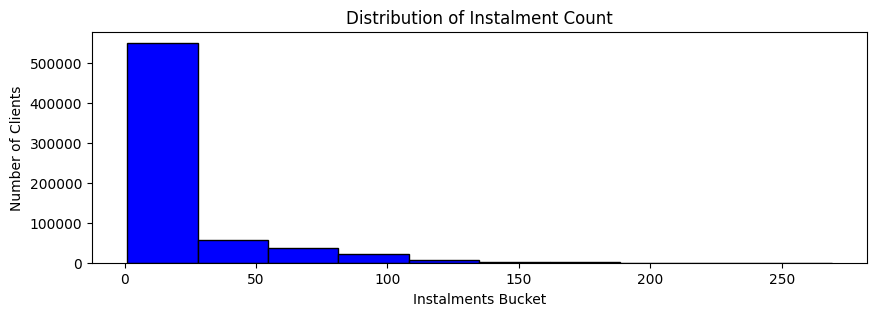

In [342]:
plt.figure(figsize=(10,3))
plt.hist(installments_payments['NUM_INSTALMENT_NUMBER'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Instalment Count')
plt.xlabel('Instalments Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* Most of the clients complete their instalment payment before 25 months.

### 8.2.2 Univariate Analysis : Amt_Payment

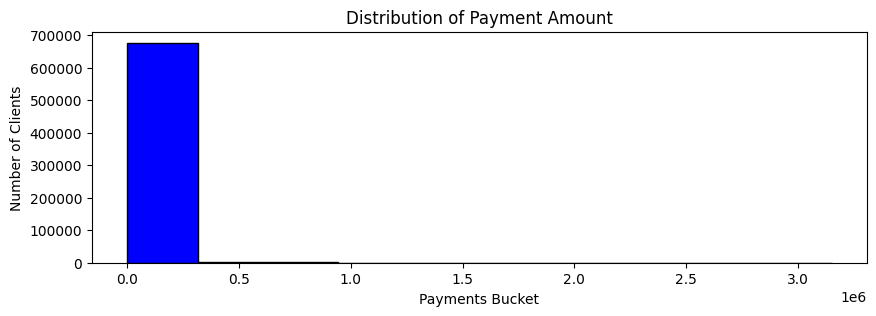

In [343]:
plt.figure(figsize=(10,3))
plt.hist(installments_payments['AMT_PAYMENT'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Payment Amount')
plt.xlabel('Payments Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* Most of the clients paid less than 5 lakh on previous credit on the same installment.

<h2> 8.3 Feature Engineering on Installments Payments Data</h2>

<h4> Function to carry out Feature Engineering for Multiple features </h4>

In [344]:
def FE_installments_payments(installments_payments):
    
    pay1 = installments_payments[['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']+ ['AMT_PAYMENT']]
    pay2 = pay1.groupby(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT'].sum().reset_index()
    pay_final = pay2.rename(columns={'AMT_PAYMENT': 'AMT_PAYMENT_GROUPED'})
    payments_final = installments_payments.merge(pay_final,\
                            on=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], how='left')

    payments_final['PAYMENT_DIFFERENCE'] = payments_final['AMT_INSTALMENT'] - \
                                       payments_final['AMT_PAYMENT_GROUPED']
    payments_final['PAYMENT_RATIO'] = payments_final['AMT_INSTALMENT'] / payments_final['AMT_PAYMENT_GROUPED']

    payments_final['PAID_OVER_AMOUNT'] = payments_final['AMT_PAYMENT'] - \
                                     payments_final['AMT_INSTALMENT']
    payments_final['PAID_OVER'] = (payments_final['PAID_OVER_AMOUNT'] > 0).astype(int)
   
    payments_final['DPD'] = payments_final['DAYS_ENTRY_PAYMENT'] - \
                        payments_final['DAYS_INSTALMENT']
    payments_final['DPD'] = payments_final['DPD'].apply(lambda x: 0 if x <= 0 else x)

    payments_final['DBD'] = payments_final['DAYS_INSTALMENT'] - \
                        payments_final['DAYS_ENTRY_PAYMENT']
    payments_final['DBD'] = payments_final['DBD'].apply(lambda x: 0 if x <= 0 else x)
    payments_final['LATE_PAYMENT'] = payments_final['DBD'].apply(lambda x: 1 if x > 0 else 0)
    
    payments_final['INSTALMENT_PAYMENT_RATIO'] = payments_final['AMT_PAYMENT'] / payments_final['AMT_INSTALMENT']
    payments_final['LATE_PAYMENT_RATIO'] = payments_final.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

    payments_final['SIGNIFICANT_LATE_PAYMENT'] = payments_final['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)

    payments_final['DPD_7'] = payments_final['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    payments_final['DPD_15'] = payments_final['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    payments_final['DPD_30'] = payments_final['DPD'].apply(lambda x: 1 if x >= 30 else 0)
    payments_final['DPD_60'] = payments_final['DPD'].apply(lambda x: 1 if x >= 60 else 0)
    payments_final['DPD_90'] = payments_final['DPD'].apply(lambda x: 1 if x >= 90 else 0)
    payments_final['DPD_180'] = payments_final['DPD'].apply(lambda x: 1 if x >= 180 else 0)
    payments_final['DPD_WOF'] = payments_final['DPD'].apply(lambda x: 1 if x >= 720 else 0)
    
    payments_final, pay_final_columns = one_hot_encode(payments_final)

    numeric_agg_payments = {'LATE_PAYMENT': ['max','mean','min'],'AMT_PAYMENT': ['min', 'max',\
                      'mean', 'sum'], 'NUM_INSTALMENT_VERSION': ['nunique'], \
                      'NUM_INSTALMENT_NUMBER':['max'], 'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'PAYMENT_DIFFERENCE': ['max','mean','min','sum'],'DAYS_ENTRY_PAYMENT': ['max', \
        'mean', 'sum'],  'PAID_OVER_AMOUNT': ['max','mean','min']
               }

    for col in pay_final_columns:
        numeric_agg_payments[col] = ['mean']
    
    payments_final_agg = payments_final.groupby('SK_ID_CURR').agg(numeric_agg_payments)
    col_list_9=[]

    for col in payments_final_agg.columns.tolist():
        col_list_9.append('INS_'+col[0]+'_'+col[1].upper())

    payments_final_agg.columns = pd.Index(col_list_9)
    payments_final_agg['INSTALLATION_COUNT'] = payments_final.groupby('SK_ID_CURR').size()
    
    del payments_final
    gc.collect()
    
    return payments_final_agg

<h4> Function to carry out Feature Engineering using 'Days_Instalment' </h4>

In [345]:
def FE_installments_payments_days_instalment(data, data_temp, installments_payments):

    installments_payments['DAYS_ENTRY_PAYMENT'].fillna(0, inplace=True)
    installments_payments['AMT_PAYMENT'].fillna(0.0, inplace=True)

    temp_13 = FE_installments_payments(reduce_memory_usage(installments_payments))
    data = data_temp.join(temp_13, how='left', on='SK_ID_CURR')
    del temp_13
    gc.collect()

    temp_14 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-365].reset_index())
    temp_14.drop(['index'], axis=1, inplace=True)
    temp_14 = FE_installments_payments(temp_14)
    data = data.join(temp_14, how='left', on='SK_ID_CURR', rsuffix='_year')
    del temp_14
    gc.collect()

    temp_15 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-182].reset_index())
    temp_15.drop(['index'], axis=1, inplace=True)
    temp_15 = FE_installments_payments(temp_15)
    data = data.join(temp_15, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_15
    gc.collect()

    temp_16 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-90].reset_index())
    temp_16.drop(['index'], axis=1, inplace=True)
    temp_16 = FE_installments_payments(temp_16)
    data = data.join(temp_16, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_16
    gc.collect()

    temp_17 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-30].reset_index())
    temp_17.drop(['index'], axis=1, inplace=True)
    temp_17 = FE_installments_payments(temp_17)
    data = data.join(temp_17, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_17
    gc.collect()
   
    temp_18 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-14].reset_index())
    temp_18.drop(['index'], axis=1, inplace=True)
    temp_18 = FE_installments_payments(temp_18)
    data = data.join(temp_18, how='left', on='SK_ID_CURR', rsuffix='_fortnight')
    del temp_18
    gc.collect()

    temp_19 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-7].reset_index())
    temp_19.drop(['index'], axis=1, inplace=True)
    temp_19 = FE_installments_payments(temp_19)
    data = data.join(temp_19, how='left', on='SK_ID_CURR', rsuffix='_week')
    del temp_19
    gc.collect()
    
    return data

<h4> Carrying out Feature Engineering using the Functions Defined </h4>

In [346]:
train_data_temp_2 = FE_installments_payments_days_instalment(train_data,train_data_temp_2,installments_payments)
train_data_temp_2.shape

Memory usage of dataframe is 20.76 MB
Memory usage after optimization is: 20.76 MB
Decreased by 0.0%
Memory usage of dataframe is 5.25 MB
Memory usage after optimization is: 4.59 MB
Decreased by 12.5%
Memory usage of dataframe is 2.55 MB
Memory usage after optimization is: 2.23 MB
Decreased by 12.5%
Memory usage of dataframe is 1.17 MB
Memory usage after optimization is: 1.03 MB
Decreased by 12.5%
Memory usage of dataframe is 0.33 MB
Memory usage after optimization is: 0.29 MB
Decreased by 12.5%
Memory usage of dataframe is 0.13 MB
Memory usage after optimization is: 0.11 MB
Decreased by 12.5%
Memory usage of dataframe is 0.05 MB
Memory usage after optimization is: 0.04 MB
Decreased by 12.5%


(15375, 2269)

<h1> 9. Credit Card Balance Dataset </h1>

<h2>9.1. Basic Overview of the 'Credit Card Balance' Dataset </h2>

In [347]:
credit_card_balance = reduce_memory_usage(pd.read_csv('../data/home-credit-default-risk/credit_card_balance.csv'))
rows_to_keep = int(len(credit_card_balance) * reduce_ratio)
credit_card_balance = credit_card_balance.sample(n=rows_to_keep, random_state=42)
print('Number of data points : ', credit_card_balance.shape[0])
print('Number of features : ', credit_card_balance.shape[1])
credit_card_balance.head()

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Number of data points :  192015
Number of features :  23


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2515502,2229653,284348,-45,136399.640625,135000,0.0,0.0,0.0,0.0,6750.000000,...,136399.640625,136399.640625,0.0,0,0.0,0.0,48.0,Active,1,1
1307940,1786293,156412,-77,0.000000,90000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,5.0,Active,0,0
318549,2199394,397441,-88,0.000000,180000,0.0,0.0,0.0,0.0,9000.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,1.0,Active,0,0
2558004,1171732,364620,-6,345647.437500,337500,84600.0,84600.0,0.0,0.0,16579.214844,...,335103.937500,335103.937500,6.0,6,0.0,0.0,2.0,Active,0,0
3802735,1798989,361308,-69,93392.507812,202500,0.0,0.0,0.0,0.0,10125.000000,...,93392.507812,93392.507812,0.0,0,0.0,0.0,18.0,Active,0,0


In [348]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

<h2> 9.2 Credit Card Balance EDA </h2>

### 9.2.1 Univariate Analysis : Months_Balance

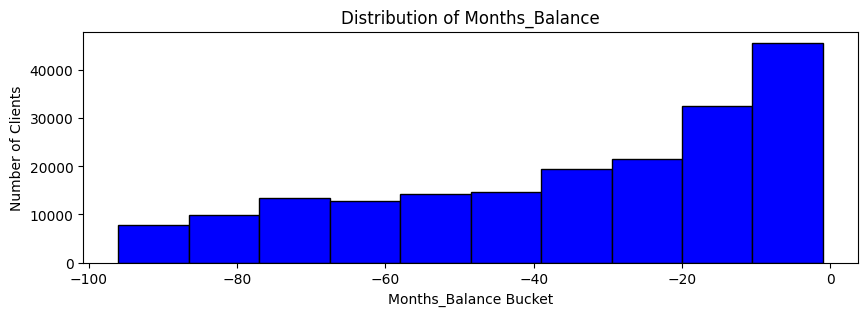

In [349]:
plt.figure(figsize=(10,3))
plt.hist(credit_card_balance['MONTHS_BALANCE'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Months_Balance')
plt.xlabel('Months_Balance Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* Most of the clients have Months_Balance between 0-10 months before the application date.

### 9.2.2 Univariate Analysis : Cnt_Drawings_Current

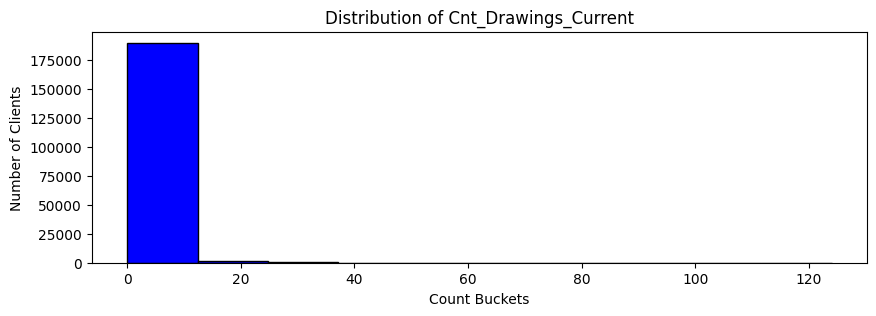

In [350]:
plt.figure(figsize=(10,3))
plt.hist(credit_card_balance['CNT_DRAWINGS_CURRENT'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Cnt_Drawings_Current')
plt.xlabel('Count Buckets')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* The vast majority of the clients have less than 25 months of drawing in the current month on the previous credit, except a very small number of outliers.

### 9.2.3 Univariate Analysis : Cnt_Instalment_Mature_Cum

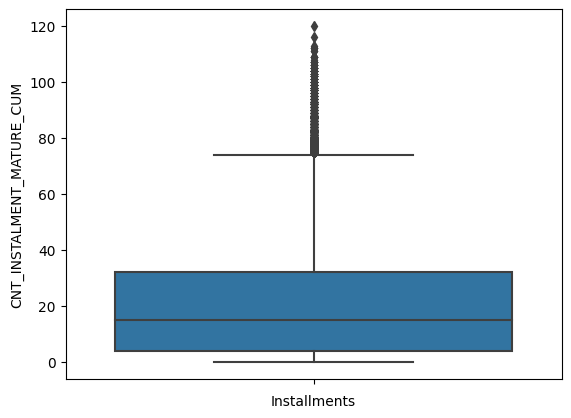

In [351]:
sns.boxplot(y='CNT_INSTALMENT_MATURE_CUM', data=credit_card_balance)
plt.xlabel('Installments')
plt.show()

In [352]:
credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].describe()

count    176365.0
mean          NaN
std           0.0
min           0.0
25%           4.0
50%          15.0
75%          32.0
max         120.0
Name: CNT_INSTALMENT_MATURE_CUM, dtype: float64

<h4> Observations : </h4>

* As we can see from the Boxplot and the detailed Feature Description of 'Cnt_Instalment_Mature_Cum' (number of paid instalments on the previous credit), the minimum value is 0 whereas the maximum value is 120.
* 75% of the total values lying are less than 32.

<h2> 9.3 Feature Engineering on Credit Card Balance Data </h2>

<h4> Function to carry out Feature Engineering for Multiple features </h4>

In [353]:
def FE_credit_card_balance(credit_card_balance):
    
    cc_balance_data, cc_balance_columns = one_hot_encode(credit_card_balance)
    cc_balance_data.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)

    cc_balance_data['LIMIT_USE'] = cc_balance_data['AMT_BALANCE'] / cc_balance_data['AMT_CREDIT_LIMIT_ACTUAL']
    cc_balance_data['PAYMENT_DIV_MIN'] = cc_balance_data['AMT_PAYMENT_CURRENT'] / cc_balance_data['AMT_INST_MIN_REGULARITY']
    cc_balance_data['LATE_PAYMENT'] = cc_balance_data['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    
    cc_balance_data['DRAWING_LIMIT_RATIO'] = cc_balance_data['AMT_DRAWINGS_ATM_CURRENT'] / cc_balance_data['AMT_CREDIT_LIMIT_ACTUAL']

    cc_balance_data.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_balance_data_agg = cc_balance_data.groupby('SK_ID_CURR').agg(['max', 'mean', 'sum', 'var'])
    
    col_list_9=[]

    for col in cc_balance_data_agg.columns.tolist():
        col_list_9.append('CR_'+col[0]+'_'+col[1].upper())
    
    cc_balance_data_agg.columns = pd.Index(col_list_9)

    cc_balance_data_agg['CREDIT_COUNT'] = cc_balance_data.groupby('SK_ID_CURR').size()
    
    del cc_balance_data, cc_balance_columns
    gc.collect()
    
    return cc_balance_data_agg

<h4> Function to carry out Feature Engineering using 'Months_Balance' </h4>

In [354]:
def FE_credit_card_balance_months_balance(data,data_temp,credit_card_balance):
    
    temp_20 = FE_credit_card_balance(reduce_memory_usage(credit_card_balance))
    data = data_temp.join(temp_20, how='left', on='SK_ID_CURR')
    del temp_20
    gc.collect()
    
    temp_21 = reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-12].reset_index())
    temp_21.drop(['index'], axis=1, inplace=True)
    temp_21 = FE_credit_card_balance(temp_21)
    data = data.join(temp_21, how='left', on='SK_ID_CURR', rsuffix='_year')
    del temp_21
    gc.collect()

    temp_22 = reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-6].reset_index())
    temp_22.drop(['index'], axis=1, inplace=True)
    temp_22 = FE_credit_card_balance(temp_22)
    data = data.join(temp_22, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_22
    gc.collect()

    temp_23 = reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-3].reset_index())
    temp_23.drop(['index'], axis=1, inplace=True)
    temp_23 = FE_credit_card_balance(temp_23)
    data = data.join(temp_23, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_23
    gc.collect()

    temp_24 = reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-1].reset_index())
    temp_24.drop(['index'], axis=1, inplace=True)
    temp_24 = FE_credit_card_balance(temp_24)
    data = data.join(temp_24, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_24
    gc.collect()
    
    return data

<h4> Carrying out Feature Engineering using the Functions Defined </h4>

In [355]:
train_data_temp_2 = FE_credit_card_balance_months_balance(train_data,train_data_temp_2,credit_card_balance)
train_data_temp_2.shape

Memory usage of dataframe is 15.93 MB
Memory usage after optimization is: 15.38 MB
Decreased by 3.4%


Memory usage of dataframe is 4.27 MB
Memory usage after optimization is: 4.06 MB
Decreased by 4.8%
Memory usage of dataframe is 2.25 MB
Memory usage after optimization is: 2.14 MB
Decreased by 4.8%
Memory usage of dataframe is 1.03 MB
Memory usage after optimization is: 0.98 MB
Decreased by 4.8%
Memory usage of dataframe is 0.25 MB
Memory usage after optimization is: 0.24 MB
Decreased by 5.9%


(15375, 2850)

<h3> * Duplicate Feature Removal </h3>

In [356]:
#Removing any duplicate features, if any are present in the final dataset
train_data = train_data_temp_2.loc[:,~train_data_temp_2.columns.duplicated()]
train_data.shape

(15375, 2850)

<h1> 10. Featurization on the Test Data </h1>

In [357]:
start = datetime.now()

# rows_to_keep = int(len(test_data) * reduce_ratio)
# test_data = test_data.sample(n=rows_to_keep, random_state=42)

test_data = fix_nulls_outliers(test_data)

test_data_temp_1 = FE_application_data(test_data)
bureau_data_balance_final = FE_bureau_data_2(bureau_data, bureau_balance,bureau_data_columns,\
                                             bureau_balance_columns)
test_data_temp_2 = test_data_temp_1.join(bureau_data_balance_final, how='left', on='SK_ID_CURR')

print("="*100)
test_data_temp_2 = FE_previous_application_days_decision(test_data, test_data_temp_2,previous_application)
print("="*100)
print(" "*100)

print("="*100)
test_data_temp_2 = FE_pos_cash_balance_months_balance(test_data,test_data_temp_2, pos_cash_balance)
print("="*100)
print(" "*100)

print("="*100)
test_data_temp_2 = FE_installments_payments_days_instalment(test_data,test_data_temp_2,installments_payments)
print("="*100)
print(" "*100)

print("="*100)
test_data_temp_2 = FE_credit_card_balance_months_balance(test_data,test_data_temp_2,credit_card_balance)
print("="*100)
print(" "*100)

test_data = test_data_temp_2.loc[:,~test_data_temp_2.columns.duplicated()]

print(" "*100)
print("Time taken to run this cell :", datetime.now() - start)

Memory usage of dataframe is 15.29 MB
Memory usage after optimization is: 15.29 MB
Decreased by 0.0%
Memory usage of dataframe is 5.28 MB
Memory usage after optimization is: 5.17 MB
Decreased by 2.1%
Memory usage of dataframe is 2.05 MB
Memory usage after optimization is: 2.01 MB
Decreased by 2.1%
Memory usage of dataframe is 0.82 MB
Memory usage after optimization is: 0.80 MB
Decreased by 2.6%
Memory usage of dataframe is 0.34 MB
Memory usage after optimization is: 0.33 MB
Decreased by 3.6%
Memory usage of dataframe is 0.16 MB
Memory usage after optimization is: 0.16 MB
Decreased by 3.6%
Memory usage of dataframe is 0.08 MB
Memory usage after optimization is: 0.09 MB
Decreased by -4.7%
                                                                                                    
Memory usage of dataframe is 15.74 MB
Memory usage after optimization is: 15.74 MB
Decreased by 0.0%
Memory usage of dataframe is 3.67 MB
Memory usage after optimization is: 3.22 MB
Decreased by 12.1%
Me

<h1> 10. Before Building the ML Models </h1>

<h2>10.1. Train Test Split of the Data </h2>

* Before we build actual ML Models on our dataset, we try and carry out a Train-Test Split. The number of datapoints that we obtain in each of these datasets is as shown.

In [358]:
print('Shape of the Train Data: {}'.format(train_data.shape))
print('Shape of the Test Data: {}'.format(test_data.shape))

Shape of the Train Data: (15375, 2850)
Shape of the Test Data: (48744, 2851)


In [359]:
X_data_train = train_data.drop(['TARGET'], axis=1) 
#For the X_data_train we select all the columns except the TARGET column that has the class labels

Y_data_train = train_data['TARGET']
#For the Y_data_train, we select only the TARGET column

In [360]:
X_train_final, X_cv_final, Y_train_final, Y_cv_final = train_test_split(X_data_train, Y_data_train, test_size=0.20, \
                                                                        stratify=Y_data_train)
print(X_train_final.shape, Y_train_final.shape)
print(X_cv_final.shape, Y_cv_final.shape)

(12300, 2849) (12300,)
(3075, 2849) (3075,)


<h2>10.2. Pickling Dataframes obtained for Future Use </h2>

In [363]:
#Pickling the Dataframes obtained for future use:-

import pandas as pd
import pickle
import os

if not os.path.isfile('pickles/train_data.pkl'):
    train_data.to_pickle('pickles/train_data.pkl')
train_data = pd.read_pickle('pickles/train_data.pkl')

if not os.path.isfile('pickles/test_data'):
    test_data.to_pickle('pickles/test_data')
test_data = pd.read_pickle('pickles/test_data')

if not os.path.isfile('pickles/X_train_final_hcdr_new'):
    X_train_final.to_pickle('pickles/X_train_final_hcdr_new')
X_train_final_hcdr_new = pd.read_pickle('pickles/X_train_final_hcdr_new')

if not os.path.isfile('pickles/Y_train_final_hcdr_new'):
    Y_train_final.to_pickle('pickles/Y_train_final_hcdr_new')
Y_train_final_hcdr_new = pd.read_pickle('pickles/Y_train_final_hcdr_new')

if not os.path.isfile('pickles/X_cv_final_hcdr_new'):
    X_cv_final.to_pickle('pickles/X_cv_final_hcdr_new')
X_cv_final_hcdr_new = pd.read_pickle('pickles/X_cv_final_hcdr_new')

if not os.path.isfile('pickles/Y_cv_final_hcdr_new'):
    Y_cv_final.to_pickle('pickles/Y_cv_final_hcdr_new')
Y_cv_final_hcdr_new = pd.read_pickle('pickles/Y_cv_final_hcdr_new')

if not os.path.isfile('pickles/X_data_train'):
    X_data_train.to_pickle('pickles/X_data_train')
X_data_train = pd.read_pickle('pickles/X_data_train')

if not os.path.isfile('pickles/Y_data_train'):
    Y_data_train.to_pickle('pickles/Y_data_train')
Y_data_train = pd.read_pickle('pickles/Y_data_train')

<h2>10.3. Obtaining Dataframe from only Top 500 Most Important Features </h2>

In [364]:
X_train_final_arr = np.nan_to_num(X_train_final_hcdr_new)
X_train_final_arr = X_train_final_arr.astype(float)
X_train_final_arr = np.nan_to_num(X_train_final_arr, nan=-1)

X_cv_final_arr = np.nan_to_num(X_cv_final_hcdr_new)
X_cv_final_arr = X_cv_final_arr.astype(float)
X_cv_final_arr = np.nan_to_num(X_cv_final_arr, nan=-1)

S = SelectKBest(f_classif, k=500)

X_train_k_best = S.fit_transform(X_train_final_arr, Y_train_final_hcdr_new)
X_cv_k_best = S.transform(X_cv_final_arr)

# Get columns to keep and create new dataframe with those only
cols = S.get_support(indices=True)

features_top_df_train = X_train_final_hcdr_new.iloc[:,cols]
features_top_df_cv = X_cv_final_hcdr_new.iloc[:,cols]



# X_train_final_arr = np.nan_to_num(X_train_final_hcdr_new)
# X_cv_final_arr = np.nan_to_num(X_cv_final_hcdr_new)

# S = SelectKBest(f_classif, k=500)

# X_train_k_best = S.fit_transform(X_train_final_arr, Y_train_final_hcdr_new)
# X_cv_k_best = S.transform(X_cv_final_arr)

# # Get columns to keep and create new dataframe with those only
# cols = S.get_support(indices=True)

# features_top_df_train = X_train_final_hcdr_new.iloc[:,cols]
# features_top_df_cv = X_cv_final_hcdr_new.iloc[:,cols]

In [365]:
if not os.path.isfile('pickles/features_top_df_train.pkl'):
    features_top_df_train.to_pickle('pickles/features_top_df_train.pkl')
features_top_df_train = pd.read_pickle('pickles/features_top_df_train.pkl')

<h2>10.4. Distribution of y_i's in Train and Cross Validation datasets </h2>

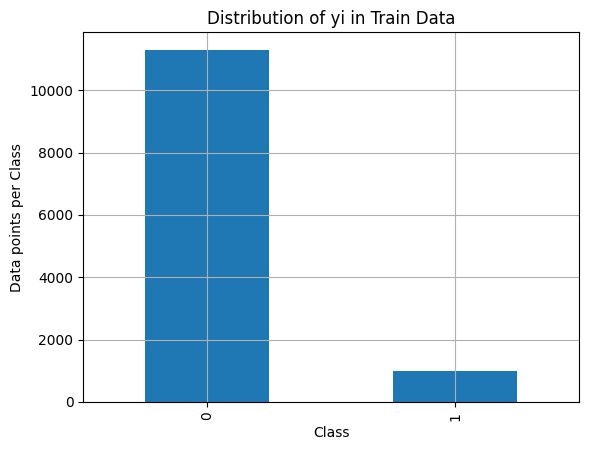

Number of data points in class 0 : 11297 ( 91.846 %)
Number of data points in class 1 : 1003 ( 8.154 %)
--------------------------------------------------------------------------------


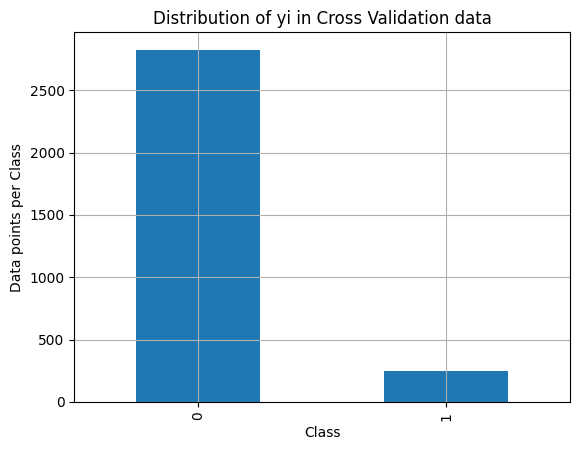

Number of data points in class 0 : 2824 ( 91.837 %)
Number of data points in class 1 : 251 ( 8.163 %)


In [366]:
# it returns a dict, keys as class labels and values as the number of data points in that class
Y_train_final_hcdr_new = Y_train_final_hcdr_new.to_frame()
Y_cv_final_hcdr_new = Y_cv_final_hcdr_new.to_frame()

train_class_distribution = Y_train_final_hcdr_new['TARGET'].value_counts().sort_index()
cv_class_distribution = Y_cv_final_hcdr_new['TARGET'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in Train Data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i, ':',train_class_distribution.values[i], \
        '(', np.round((train_class_distribution.values[i]/Y_train_final_hcdr_new.shape[0]*100), 3), '%)')
print('-'*80)

my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in Cross Validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i, ':',cv_class_distribution.values[i], \
          '(', np.round((cv_class_distribution.values[i]/Y_cv_final_hcdr_new.shape[0]*100), 3), '%)')


<h2>10.5. Standardizing the Final Dataset Obtained </h2>

In [367]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

features_top_df_test = test_data[features_top_df_train.columns]

features_top_df_test_final = np.nan_to_num(features_top_df_test, nan=0, posinf=1, neginf=-1, copy=True)
features_top_df_test_final = features_top_df_test_final.astype(float)
features_top_df_test_final = np.nan_to_num(features_top_df_test_final, nan=-1)

features_top_df_cv_final = np.nan_to_num(features_top_df_cv, nan=0, posinf=1, neginf=-1, copy=True)
features_top_df_cv_final = features_top_df_cv_final.astype(float)
features_top_df_cv_final = np.nan_to_num(features_top_df_cv_final, nan=-1)

scaler.fit(features_top_df_train)
scaler_train = scaler.transform(features_top_df_train)

scaler_cv = scaler.transform(features_top_df_cv_final)
scaler_test = scaler.transform(features_top_df_test_final)

Y_train_final_hcdr_new = np.nan_to_num(Y_train_final_hcdr_new)
Y_cv_final_hcdr_new = np.nan_to_num(Y_cv_final_hcdr_new)

scaler_train = np.nan_to_num(scaler_train)
scaler_cv = np.nan_to_num(scaler_cv)
scaler_test = np.nan_to_num(scaler_test)



# --------------------------------------------------------------------------------------------
# scaler = StandardScaler()

# features_top_df_test = test_data[features_top_df_train.columns]
# features_top_df_test_final = np.nan_to_num(features_top_df_test)
# features_top_df_cv_final = np.nan_to_num(features_top_df_cv)

# scaler.fit(features_top_df_train)
# scaler_train = scaler.transform(features_top_df_train)
# scaler_cv = scaler.transform(features_top_df_cv_final)
# scaler_test = scaler.transform(features_top_df_test_final)

# Y_train_final_hcdr_new = np.nan_to_num(Y_train_final_hcdr_new)
# Y_cv_final_hcdr_new = np.nan_to_num(Y_cv_final_hcdr_new)

# scaler_train = np.nan_to_num(scaler_train)
# scaler_cv = np.nan_to_num(scaler_cv)
# scaler_test = np.nan_to_num(scaler_test)

<h2>10.6. Additional Functions </h2>

<h4> Function to obtain predictions by Batches </h4>

In [368]:
def batch_predict(clf, data):
   
    y_data_pred = []
    loop_count = data.shape[0] - data.shape[0]%1000
   
    for i in range(0, loop_count, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    y_data_pred.extend(clf.predict_proba(data[loop_count:])[:,1])
    
    return y_data_pred

<h4> Function to obtain Ideal value of Threshold </h4>

In [369]:
def obtain_threshold(thresholds,tpr,fpr):   
    
    obtain_threshold.best_tradeoff = tpr*(1-fpr)
    ideal_threshold = thresholds[obtain_threshold.best_tradeoff.argmax()]
 
    return ideal_threshold

<h4> Function to obtain the Confusion, Precision & Recall Matrices </h4>

In [370]:
def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
   
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
   
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.set(font_scale=1.1)
    sns.set_style(style='white')
    
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, \
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B,annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, \
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, \
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h1>11. Machine Learning Models</h1>

<h2>11.1. Logistic Regression </h2>

<h3> 11.1.1 Hyperparameter Tuning on the CV Data </h3>

For values of alpha =  1e-05 the roc_auc score is: 0.5
For values of alpha =  0.0001 the roc_auc score is: 0.5
For values of alpha =  0.001 the roc_auc score is: 0.5
For values of alpha =  0.01 the roc_auc score is: 0.5
For values of alpha =  0.1 the roc_auc score is: 0.5
For values of alpha =  1 the roc_auc score is: 0.5
For values of alpha =  10 the roc_auc score is: 0.5


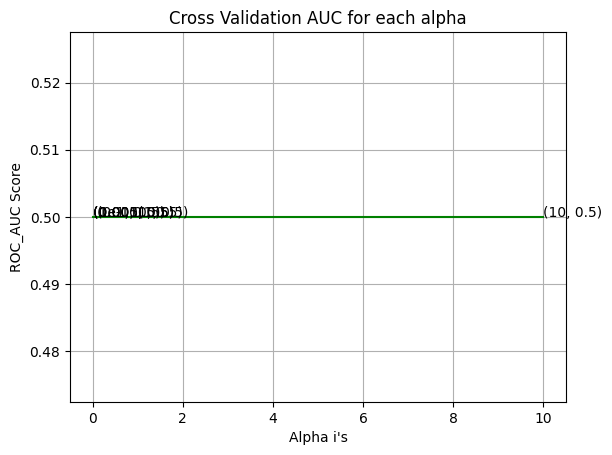

For values of best alpha =  1e-05 The train roc_auc is: 0.5
For values of best alpha =  1e-05 The cv roc_auc is: 0.5
                                                                                                    
Time taken to run this cell : 0:00:17.031976


In [371]:
# Y_cv_final_hcdr_new = Y_cv_final_hcdr_new.astype(float)
# Y_cv_final_hcdr_new = np.nan_to_num(Y_cv_final_hcdr_new, nan=-1)

# has_nan = np.isnan(Y_cv_final_hcdr_new).any()

# if has_nan:
#     print("The array still contains NaN values")
# else:
#     print("The array no longer contains NaN values")

import statistics


alpha = [10 ** x for x in range(-5, 2)] # hyperparameter for SGD classifier.

train_auc=[]
cv_auc=[]

roc_auc_array=[]

start = datetime.now()

roc_auc_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42,\
                        class_weight='balanced')
    clf.fit(scaler_train, Y_train_final_hcdr_new)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(scaler_train, Y_train_final_hcdr_new)
    
    Y_train_pred = batch_predict(sig_clf, scaler_train)
    Y_cv_pred = batch_predict(sig_clf, scaler_cv)
    # -----------------------------------------------------------------
    Y_cv_pred = [x if not math.isnan(x) else np.nanmean(Y_cv_pred) for x in Y_cv_pred]
    # -----------------------------------------------------------------
    
    train_auc.append(roc_auc_score(Y_train_final_hcdr_new,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv_final_hcdr_new,Y_cv_pred))

    roc_auc_array.append(roc_auc_score(Y_cv_final_hcdr_new, Y_cv_pred))
    print('For values of alpha = ', i, "the roc_auc score is:", roc_auc_score(Y_cv_final_hcdr_new,Y_cv_pred))

fig, ax = plt.subplots()
ax.plot(alpha, roc_auc_array,c='g')
for i, txt in enumerate(np.round(roc_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],roc_auc_array[i]))
plt.grid()
plt.title("Cross Validation AUC for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("ROC_AUC Score")
plt.show()

best_alpha = np.argmax(roc_auc_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)

clf.fit(scaler_train,  Y_train_final_hcdr_new)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(scaler_train, Y_train_final_hcdr_new)

predict_y_train = batch_predict(sig_clf,scaler_train)
print('For values of best alpha = ', alpha[best_alpha], "The train roc_auc is:",\
                                  roc_auc_score(Y_train_final_hcdr_new, predict_y_train))

predict_y_cv = batch_predict(sig_clf,scaler_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cv roc_auc is:",\
                                  roc_auc_score(Y_cv_final_hcdr_new, predict_y_cv))

print(" "*100)
print("Time taken to run this cell :", datetime.now() - start)

<h4> Observations :- </h4>

* In the roc_auc values that we obtained, since the values are quite close to each other for Train and CV, we can say with assurance that our model is not overfitting).
* We could have said that the model was underfitting if the Train and CV roc_auc values were approximately same as each other and had we trained a more complex model such as GBDT and this complex model gave an roc_auc score higher than 0.7202. (Since Logistic Regression is a very simple linear classifier it has a much higher chance of underfitting).

<h3> 11.1.2 Obtaining ROC Curves on Train and CV Datasets </h3>

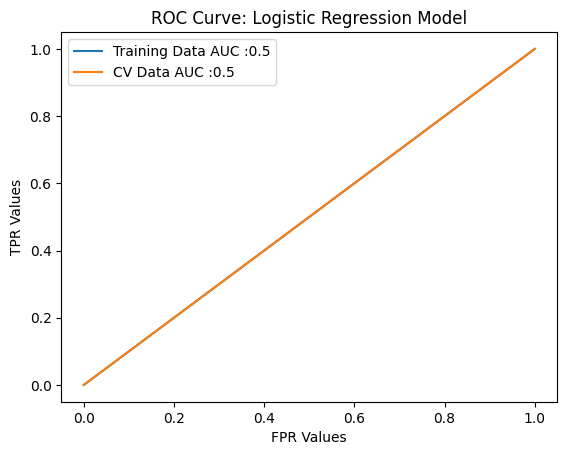

Ideal Threshold for the CV Dataset = inf
Time taken to run this cell : 0:00:02.062265


In [372]:
start = datetime.now()

clf = SGDClassifier(alpha=0.1, penalty='l2', loss='log_loss', random_state=42,class_weight='balanced')
clf.fit(scaler_train, Y_train_final_hcdr_new)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(scaler_train, Y_train_final_hcdr_new)

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(Y_train_final_hcdr_new,sig_clf.predict_proba(scaler_train)[:,1])
cv_fpr1,cv_tpr1, cv_thresholds1 = roc_curve(Y_cv_final_hcdr_new, sig_clf.predict_proba(scaler_cv)[:,1])

plt.plot(train_fpr1,train_tpr1, label ="Training Data AUC :" + str(auc(train_fpr1,train_tpr1)))
plt.plot(cv_fpr1,cv_tpr1,label="CV Data AUC :" + str(auc(cv_fpr1,cv_tpr1)))
plt.legend()

plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title('ROC Curve: Logistic Regression Model')

plt.grid(False)
plt.show()

print('Ideal Threshold for the CV Dataset =', obtain_threshold(cv_thresholds1,cv_tpr1,cv_fpr1))
print("Time taken to run this cell :", datetime.now() - start)

<h3> 11.1.3 Plotting Confusion, Precision & Recall Matrices on CV Data </h3>

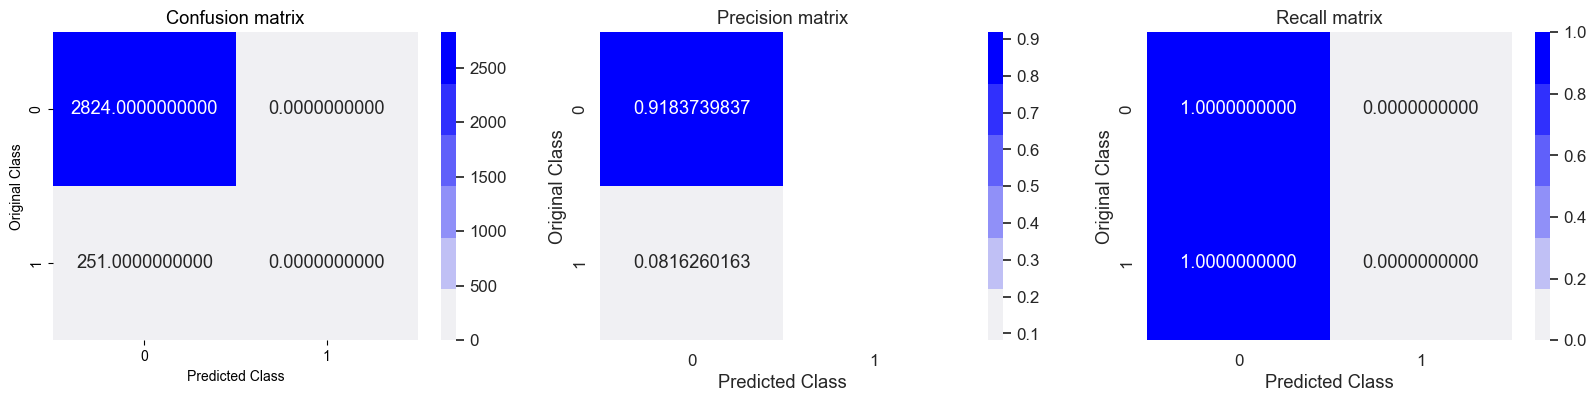

In [ ]:
Y_cv_final_plot = Y_cv_final_hcdr_new.flatten()
Y_cv_final_pred = sig_clf.predict(scaler_cv)

plot_confusion_matrix(Y_cv_final_plot, Y_cv_final_pred)

<h4> Observations :- </h4>

* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (54319 + 852)/61503 ie 89.70%.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 0, 92.96% of them actually belong to class 0 and 7.03% of them belong to class 1. Similarly of all the points that are predicted to belong to class 1, 27.74% of the points belong to class 1 and 72.25% of the points actually belong to class 0.
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 0 our model predicted 96.07% of them belonging to class 0 and 3.9% of them belonging to class 1. Similarly of all the points that originally belong to class 1, 17.16% of those points have been predicted by the model to belong to class 1 and 82.83% to belong to class 0. {This class 1 Value of Recall is the major cause of concern in this case}. The diagonal values that you see in the Recall Matrix are the Recall Values for Class 0 and the Recall values for class 1.

<h3> 11.1.4 Evaluating on the Test Dataset </h3>

In [373]:
from sklearn.linear_model import LogisticRegression

for col in features_top_df_test.columns:
    if col=='TARGET':
        features_top_df_test = features_top_df_test.drop(['TARGET'],axis=1)
    if col =='SK_ID_CURR':
        features_top_df_test = features_top_df_test.drop(['SK_ID_CURR'],axis=1)

logistic_regression = LogisticRegression(C=0.1, class_weight='balanced',random_state=42,penalty='l2')
logistic_regression.fit(scaler_train, Y_train_final_hcdr_new)

scaler_test = np.nan_to_num(scaler_test)
lr_test_predict = logistic_regression.predict_proba(scaler_test)[:,1]

In [374]:
features_top_df_test['SK_ID_CURR'] = test_data['SK_ID_CURR']
features_top_df_test['TARGET'] = lr_test_predict
features_top_df_test['SK_ID_CURR'] = features_top_df_test['SK_ID_CURR'].apply(lambda x: np.int32(x))
features_top_df_test[['SK_ID_CURR', 'TARGET']].to_csv('hcdr_logistic_regression_500f.csv', index= False)